<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Lets read the data first
house = pd.read_csv('./housing.csv')

In [4]:
# Lets check the head first
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
# Lets see the yearwise amount and count

pd.pivot_table(house, index=['YrSold'],values=['SalePrice'],aggfunc={'SalePrice':sum, 'YrSold':'count'})

SalePrice  YrSold
YrSold                   
2006     57320530     314
2007     61214777     329
2008     53917695     304
2009     60648051     338
2010     31043893     175

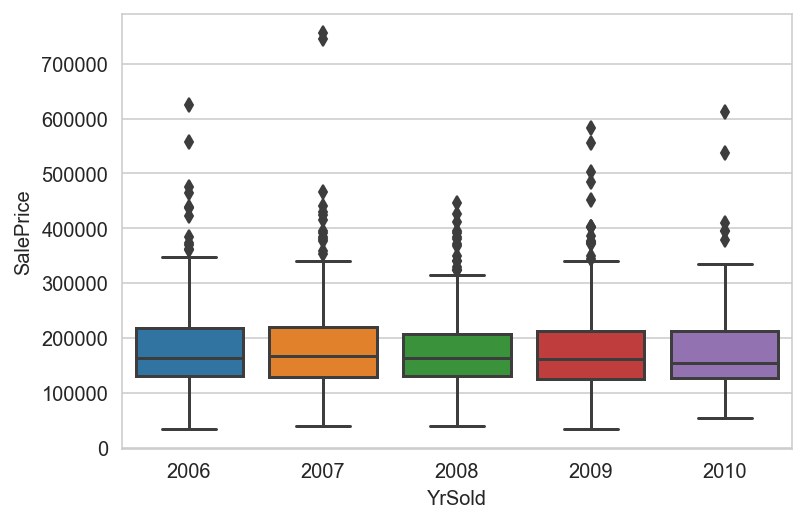

In [6]:
# lets visualize the price
import seaborn as sns
sns.boxplot(x = house['YrSold'],y = house['SalePrice'])

In [7]:
# Lets see the columns

house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
# lets check the shape
house.shape

(1460, 81)

In [9]:
# Lets see more information
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

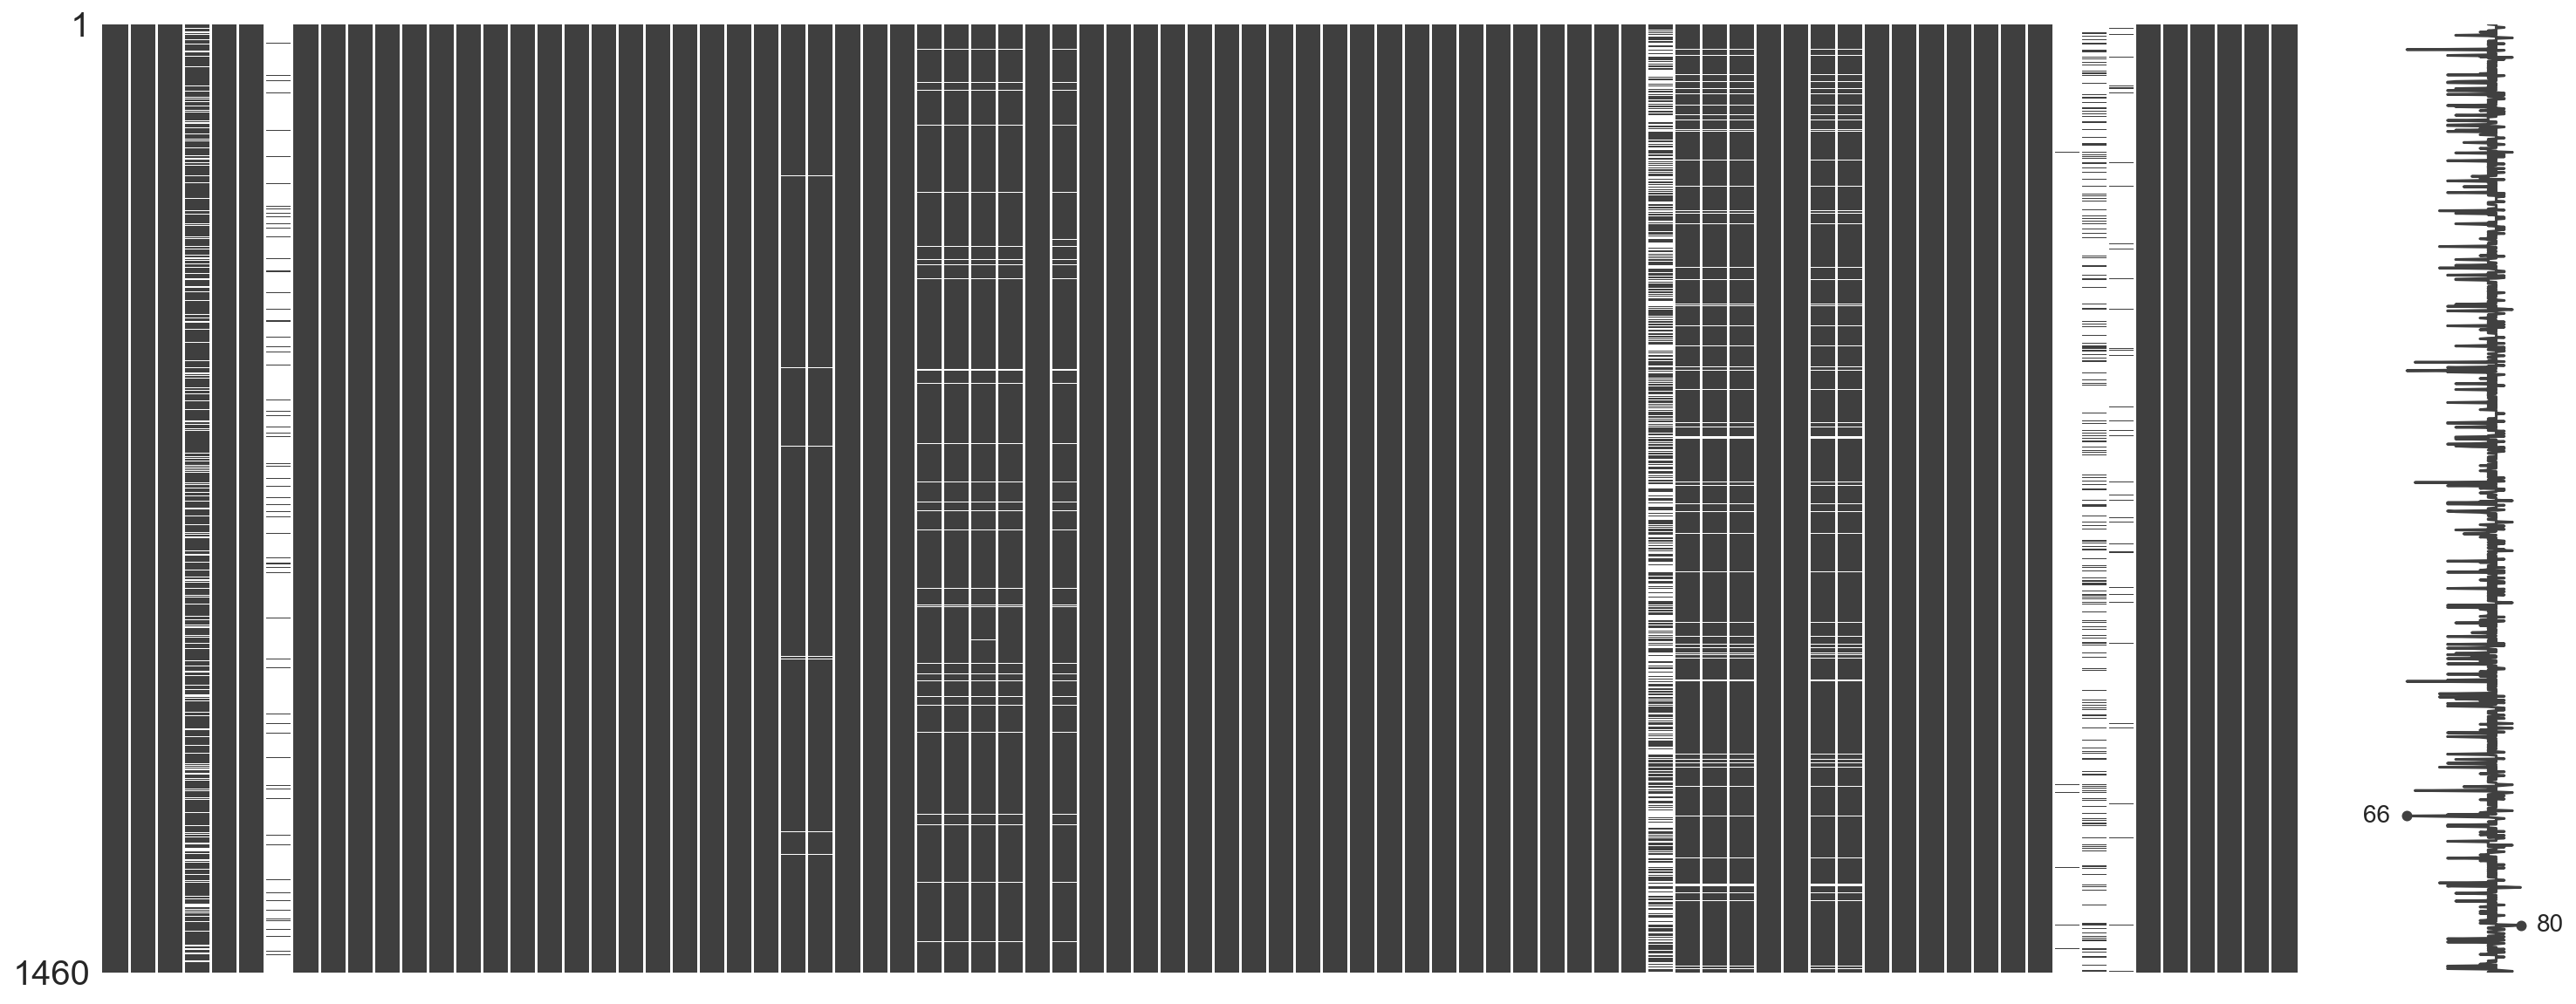

In [10]:
# lets visualize the missing values

import missingno as msno

msno.matrix(house)

In [11]:
# lets drop the columns where missing values are greater than 1000

house.drop(columns=['Id','Alley','PoolQC','Fence','MiscFeature'],inplace = True)

In [12]:
# Lets impute the Nans 

house['FireplaceQu'].fillna('No_Fireplace',inplace=True)
house['GarageType'].fillna('No Garage',inplace=True)
house['GarageFinish'].fillna('No Garage',inplace=True)
house['GarageQual'].fillna('No Garage',inplace=True)
house['GarageCond'].fillna('No Garage',inplace=True)
house['BsmtQual'].fillna('No Basement',inplace=True)
house['BsmtCond'].fillna('No Basement',inplace=True)
house['BsmtExposure'].fillna('No Basement',inplace=True)
house['BsmtFinType1'].fillna('No Basement',inplace=True)
house['BsmtFinType2'].fillna('No Basement',inplace=True)
house['MasVnrType'].fillna('None',inplace=True)
house['Electrical'].fillna('other',inplace=True)

In [13]:
# Lets impute these Nans with mean 

house['MasVnrArea'].fillna(house['MasVnrArea'].mean(),inplace=True)
house['LotFrontage'].fillna(house['LotFrontage'].mean(),inplace=True)

In [14]:
# crosschecking Nans after imputing values 

null_val = house.columns[house.isna().any()]
house[null_val].isnull().sum()

GarageYrBlt    81
dtype: int64

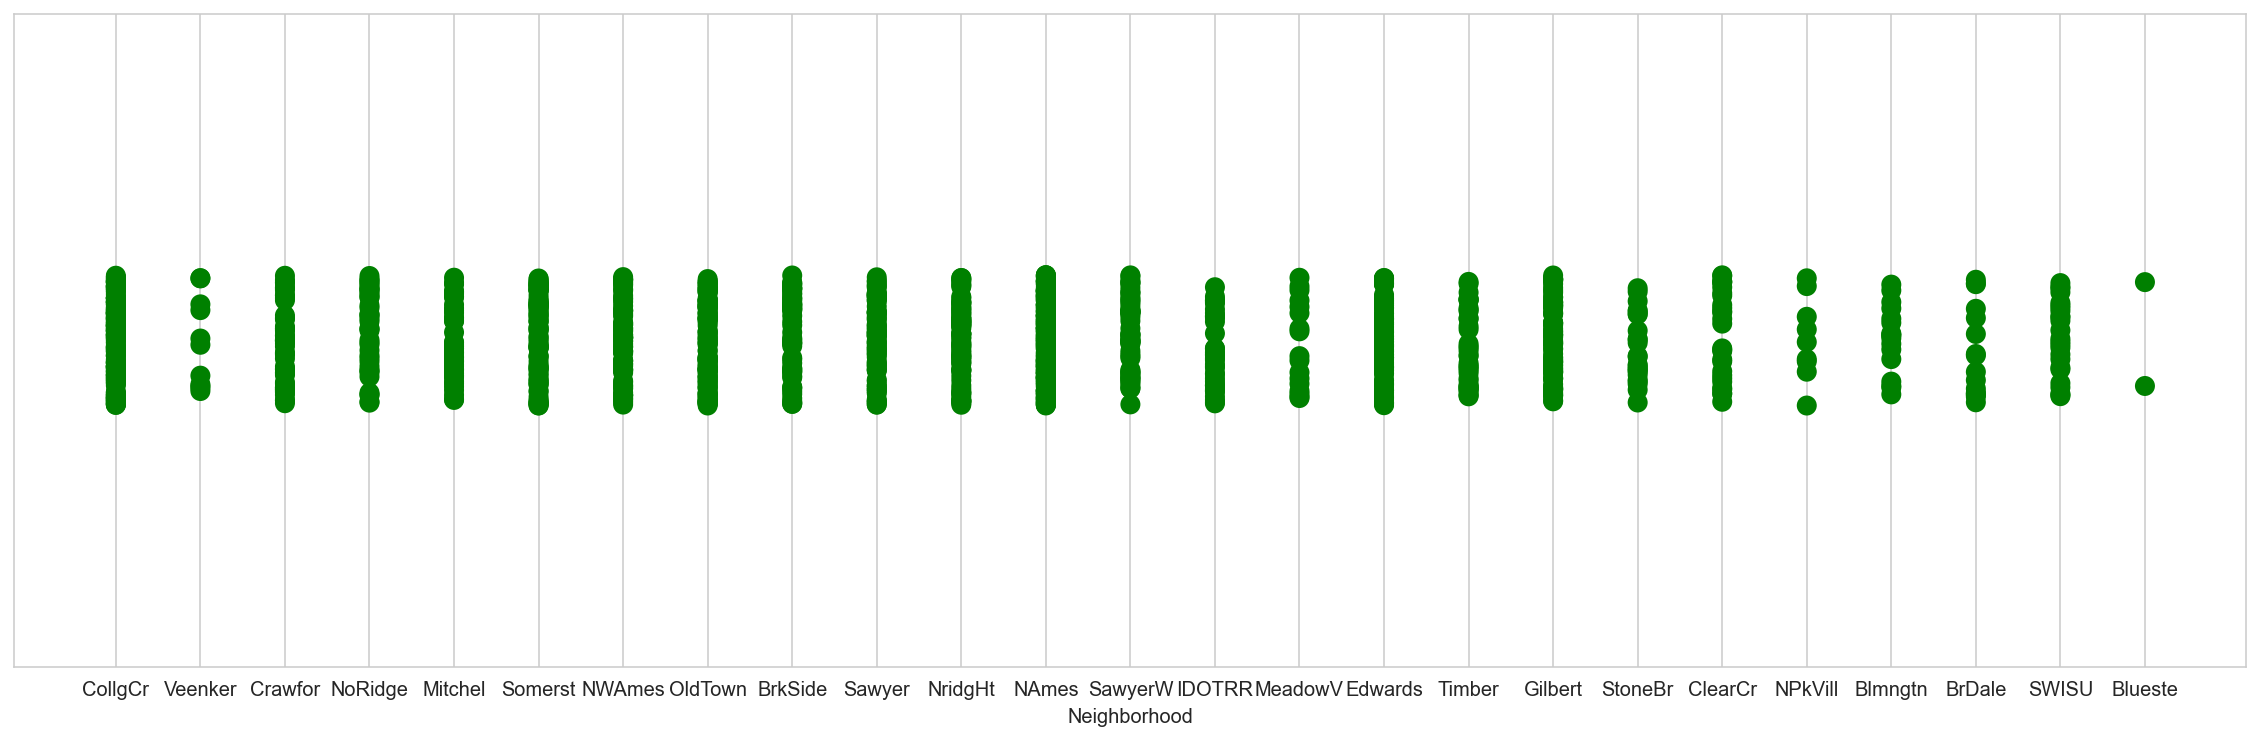

In [15]:
# lets visualise the Neighborhood column

plt.figure(figsize=(20,6))
sns.stripplot(house['Neighborhood'],color = 'g',size=10)

In [16]:
# Following are the fixed variables.

#fixed_variable = 'MSSubClass' ,'MSZoning','LotFrontage','LotArea','Street','LotShape','LandContour',
# 'Utilities','LotConfig','LandSlope','Neighborhood','BldgType','HouseStyle','YearBuilt',
# 'YearRemodAdd',,'MasVnrType','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
#'1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
#'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Functional','GarageType', 'GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',
#'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold','YrSold','SaleType','SaleCondition'

In [17]:
#Created dummies for fixed variables only

dummy = pd.get_dummies(data = house , columns =['MSZoning','MSSubClass','Street','LotShape','LandContour',
                                                'Utilities','LotConfig','LandSlope','Neighborhood','BldgType',
                                                'HouseStyle','MasVnrType','Functional','GarageType','SaleType',
                                                'SaleCondition'],drop_first=True)

In [18]:
# Lets check the shape of the fixed variables

dummy.shape

(1460, 155)

In [19]:
dummy.filter(regex='No')

Utilities_NoSeWa  Neighborhood_NoRidge  MasVnrType_None  \
0                    0                     0                0   
1                    0                     0                1   
2                    0                     0                0   
3                    0                     0                1   
4                    0                     1                0   
...                ...                   ...              ...   
1455                 0                     0                1   
1456                 0                     0                0   
1457                 0                     0                1   
1458                 0                     0                1   
1459                 0                     0                1   

      GarageType_No Garage  SaleCondition_Normal  
0                        0                     1  
1                        0                     1  
2                        0                     1  
3                        0                     0  
4                        0                     1  
...                    ...                   ...  
1455                     0                     1  
1456                     0                     1  
1457                     0                     1  
1458                     0                     1  
1459                     0                     1  

[1460 rows x 5 columns]

In [20]:
# Lets check the Nan again

dummy.columns.isna().sum()

0

In [21]:
# Created df excluding renovated variables as well as some other non-relevant columns

fixed = [c for c in dummy.columns if c not in['Utilities_NoSeWa',
                                                   'MasVnrType_None','GarageType_No Garage','Condition1',
                                                   'Condition2','OverallQual','OverallCond','RoofStyle',
                                                   'RoofMatl','Exterior1st',
'Exterior2nd','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Fireplaces',
'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','MiscFeature','MiscVal','YearBuilt',
                                                   'YearRemodAdd','GarageYrBlt']]  

In [22]:
# total data with fixed feature , excluding renovative features

fixed_df = dummy[fixed]


In [23]:
#crosschecking fixed columns
pd.set_option('max_rows',2000)
pd.set_option('max_columns', 300)
fixed_df.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=121)

In [24]:
fixed_df.shape

(1460, 121)

In [25]:
# Lets see the correlation

pd.set_option('max_rows',2000)
pd.set_option('max_columns', 300)
corr = round(fixed_df.corr(),3)
corr.style.background_gradient(cmap='coolwarm', axis=None)

# f, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True,ax=ax)

In [26]:
#Dividing data into Training and Testing

training_set = fixed_df[fixed_df['YrSold'] < 2010]
test_set = fixed_df[fixed_df['YrSold'] == 2010]
    

X_train_df = training_set.drop(columns=['SalePrice'],axis=1)
y_train = training_set['SalePrice'].values
    
X_test_df = test_set.drop(columns=['SalePrice'],axis=1)
y_test = test_set['SalePrice'].values


In [27]:
print(X_train_df.shape, y_train.shape)
print(X_test_df.shape, y_test.shape)

(1285, 120) (1285,)
(175, 120) (175,)


In [28]:
# Lets standardise the data and check the cross val score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

ss = StandardScaler()

Xs = ss.fit_transform(X_test_df)

linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y_test, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[-1.94202335e+22  2.03105040e-02 -5.39957183e+19 -7.08205868e+22
 -5.11333628e+23 -8.73311612e+22  7.44894242e-01  7.22008363e-01
 -4.75889879e+23 -1.50670895e+25]
-1.6231938962763025e+24


In [37]:
# Lets create a pipeline for Standardisation and Linear regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

ss = StandardScaler()

model = make_pipeline(StandardScaler(),LinearRegression())

model.fit(X_train_df,y_train)

yhat = model.predict(X_test_df)

scores = model.score(X_test_df,y_test)
scores

0.8608174641153988

In [38]:
# Testing score is slightly better than the training

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

pred_train_lr = model.predict(X_train_df)
print('Training score',r2_score(y_train, pred_train_lr))

pred_test_lr = model.predict(X_test_df)
print('Testing score',r2_score(y_test, pred_test_lr))

Training score 0.8436975630249303
Testing score 0.8608174641153988


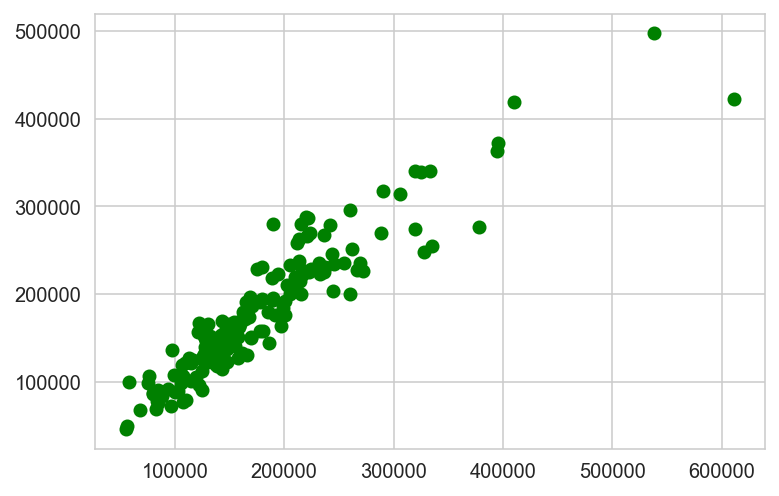

In [39]:
# Lets visualise the predictions with Linear Model

plt.scatter(y_test,yhat,color='g')

In [40]:
# Calculating the Residuals on testing dataset

prediction_on_test_set = model.predict(X_test_df)

diff_on_test_set = y_test - prediction_on_test_set

# diff_on_test_set = pd.DataFrame(columns = ['Residuals'])

# diff_on_test_set['Residuals'] = diff

#print(diff_on_test_set)


In [41]:
# Calculating the Residuals on training dataset

prediction_on_train_set = model.predict(X_train_df)

#total_difference with train data set

diff_on_train_set = y_train - prediction_on_train_set

print(diff_on_train_set)


[ -2648.49285954 -21338.43417864  19195.75714046 ... -38170.93417864
  -1797.3326348  -15805.43417864]


In [42]:
# Lets also see the intercet.

print('Intercept:', model[-1].intercept_)

Intercept: 181403.21291137542


In [43]:
# Lets see the top coef

data = pd.DataFrame(model[-1].coef_, index = X_test_df.columns , columns = ['coef'])
data.sort_values(by='coef')

coef
GrLivArea             -6.649663e+16
BsmtFinSF1            -2.479380e+16
BsmtUnfSF             -2.409607e+16
BsmtFinSF2            -8.385378e+15
BldgType_Duplex       -5.455078e+15
Neighborhood_Edwards  -1.050600e+04
Neighborhood_OldTown  -1.027950e+04
Neighborhood_NAmes    -1.003350e+04
KitchenAbvGr          -8.194593e+03
BedroomAbvGr          -7.925966e+03
Neighborhood_NWAmes   -7.390500e+03
Neighborhood_Sawyer   -6.752000e+03
MSSubClass_120        -6.320000e+03
Neighborhood_Mitchel  -5.728500e+03
MSSubClass_160        -5.358500e+03
Neighborhood_BrkSide  -4.732000e+03
Neighborhood_IDOTRR   -4.612000e+03
Neighborhood_Gilbert  -4.519250e+03
GarageArea            -3.898546e+03
GarageType_Detchd     -3.685000e+03
Neighborhood_SWISU    -3.640000e+03
Neighborhood_ClearCr  -3.443000e+03
Neighborhood_MeadowV  -3.296000e+03
Neighborhood_CollgCr  -2.974000e+03
Neighborhood_SawyerW  -2.969375e+03
LotShape_IR3          -2.855250e+03
BldgType_Twnhs        -2.763000e+03
LotFrontage           -2.626489e+03
MSSubClass_30         -2.146889e+03
GarageType_Attchd     -2.085750e+03
SaleCondition_Partial -2.048000e+03
MSSubClass_60         -1.944000e+03
BldgType_TwnhsE       -1.832000e+03
LotConfig_FR2         -1.802000e+03
MSSubClass_45         -1.800000e+03
MasVnrType_BrkFace    -1.722000e+03
Functional_Sev        -1.626000e+03
MSSubClass_190        -1.578000e+03
GarageType_CarPort    -1.483500e+03
MSSubClass_75         -1.415250e+03
Neighborhood_Timber   -1.322000e+03
MSSubClass_85         -1.246000e+03
LandSlope_Sev         -1.124000e+03
MSSubClass_180        -1.071000e+03
LotConfig_FR3         -9.735000e+02
MSSubClass_70         -9.520000e+02
Functional_Maj2       -8.485000e+02
MoSold                -8.371592e+02
MSSubClass_40         -7.400000e+02
Neighborhood_Blueste  -6.912500e+02
GarageType_BuiltIn    -6.860000e+02
Neighborhood_BrDale   -6.460000e+02
Neighborhood_NPkVill  -5.160000e+02
Neighborhood_Crawfor  -4.800000e+02
Functional_Min2       -4.170000e+02
HouseStyle_2Story     -3.600000e+02
Functional_Min1       -3.260000e+02
SaleCondition_Family  -7.200000e+01
SaleType_ConLw        -3.700000e+01
HouseStyle_2.5Fin     -2.600000e+01
LotShape_Reg          -1.150000e+01
EnclosedPorch          4.895112e+01
Functional_Mod         5.000000e+01
GarageType_Basment     8.200000e+01
PoolArea               1.504456e+02
YrSold                 2.213825e+02
MSSubClass_50          3.060000e+02
LotConfig_Inside       3.180000e+02
Neighborhood_Veenker   3.320000e+02
SaleCondition_Alloca   3.560000e+02
SaleCondition_AdjLand  6.050000e+02
HouseStyle_2.5Unf      8.940000e+02
MSSubClass_80          9.600000e+02
LandSlope_Mod          1.036000e+03
OpenPorchSF            1.206275e+03
BldgType_2fmCon        1.278000e+03
SaleType_Oth           1.288000e+03
SaleType_ConLI         1.311500e+03
MasVnrType_Stone       1.334000e+03
3SsnPorch              1.405850e+03
LotShape_IR2           1.554000e+03
SaleType_ConLD         1.808000e+03
Street_Pave            1.813375e+03
SaleType_CWD           1.974000e+03
SaleType_Con           2.290000e+03
LotConfig_CulDSac      2.328000e+03
BsmtHalfBath           2.464436e+03
Neighborhood_Somerst   2.616000e+03
LandContour_Low        2.770000e+03
MasVnrArea             2.822835e+03
SaleCondition_Normal   2.828000e+03
HalfBath               2.966290e+03
SaleType_WD            3.248000e+03
WoodDeckSF             3.310758e+03
HouseStyle_SLvl        3.356000e+03
HouseStyle_1.5Unf      3.488000e+03
MSZoning_RH            3.852612e+03
ScreenPorch            4.125026e+03
LotArea                4.127276e+03
LandContour_Lvl        4.876000e+03
HouseStyle_SFoyer      4.904000e+03
Functional_Typ         4.943000e+03
BsmtFullBath           5.249477e+03
LandContour_HLS        5.623000e+03
TotRmsAbvGrd           5.876193e+03
FullBath               6.255441e+03
Neighborhood_StoneBr   6.852000e+03
Neighborhood_NoRidge   7.394000e+03
MSZoning_FV            8.241668e+03
SaleType_New           1.132400e+04
HouseStyle_1Story      1.237200e+04

In [48]:
# Lets try Ridge now

from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

ridge = Ridge(alpha=.1)

ridge.fit(X_train_df, y_train)             # Fit a ridge regression on the training data

pred_test = ridge.predict(X_test_df)           # Use this model to predict the test data

print('mean_squared_error_test',np.sqrt(mean_squared_error(y_test,pred_test)))
print('Testing score = ',ridge.score(X_test_df, y_test))
      
pred_train = ridge.predict(X_train_df) 
      
print('mean_squared_error_train',np.sqrt(mean_squared_error(y_train,pred_train)))  
print('Training score = ',ridge.score(X_train_df, y_train))




mean_squared_error_test 29815.25259503668
Testing score =  0.8618662286575004
mean_squared_error_train 31352.049741185634
Training score =  0.8436619829600143


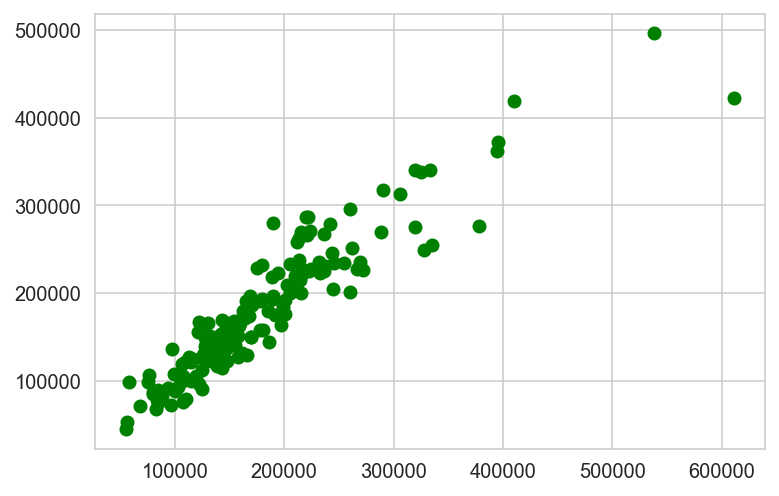

In [49]:
# lets visualize the predictions with Ridge model

plt.scatter(y_test,pred_test,color='g')

In [58]:
# Lets run Ridge without pipeline inorder to see the coef and features importance

ss = StandardScaler()

model = make_pipeline(StandardScaler(),Ridge())

model = Ridge(alpha=.1)

model.fit(X_train_df, y_train)             # Fit a ridge regression on the training data

pred_test = model.predict(X_test_df)           # Use this model to predict the test data

print('mean_squared_error_test',np.sqrt(mean_squared_error(y_test,pred_test)))
print('Testing score = ',model.score(X_test_df, y_test))
      
pred_train = model.predict(X_train_df) 
      
print('mean_squared_error_train',np.sqrt(mean_squared_error(y_train,pred_train)))  
print('Training score = ',model.score(X_train_df, y_train))

mean_squared_error_test 29815.25259503668
Testing score =  0.8618662286575004
mean_squared_error_train 31352.049741185634
Training score =  0.8436619829600143


In [59]:
# Coef with Ridge Model

ridge_data = pd.DataFrame(model.coef_,index = X_test_df.columns , columns = ['coef_ridge'])# Print coefficients
ridge_data.sort_values(by='coef_ridge')

coef_ridge
Functional_Sev        -51117.856844
Neighborhood_Edwards  -38757.046432
KitchenAbvGr          -37481.193080
Neighborhood_OldTown  -35621.041003
LotShape_IR3          -31964.071038
Neighborhood_NWAmes   -31086.196340
Neighborhood_Sawyer   -29830.932809
Neighborhood_MeadowV  -29139.197574
Neighborhood_Mitchel  -28649.063290
Neighborhood_IDOTRR   -27475.640768
Neighborhood_NAmes    -25593.558604
Neighborhood_SWISU    -25275.838117
MSSubClass_120        -24964.926396
MSSubClass_160        -24532.739854
Neighborhood_ClearCr  -22813.456463
Neighborhood_BrkSide  -20261.040537
GarageType_CarPort    -19991.464732
BldgType_Twnhs        -17416.625498
LotConfig_FR3         -17177.546127
Neighborhood_Gilbert  -17113.949061
MSSubClass_45         -15909.396572
Neighborhood_Blueste  -14496.974941
MSSubClass_40         -14073.082984
Neighborhood_SawyerW  -13558.916143
Functional_Maj2       -12463.838637
LandSlope_Sev         -11830.057284
MSSubClass_75         -10847.070512
MSSubClass_180        -10528.489326
LotConfig_FR2         -10161.704937
MSSubClass_85         -10131.169126
MSSubClass_30         -10026.976099
BedroomAbvGr           -9757.364746
MSSubClass_190         -9064.546871
GarageType_Detchd      -8329.178887
BldgType_TwnhsE        -7770.428271
Neighborhood_CollgCr   -7382.750827
Neighborhood_Timber    -6138.294692
Neighborhood_NPkVill   -5160.782310
SaleCondition_Partial  -4950.316527
GarageType_Attchd      -4279.820845
MSSubClass_60          -4183.152982
BldgType_Duplex        -4105.456411
MSSubClass_90          -4105.456411
MSSubClass_70          -4032.788592
MasVnrType_BrkFace     -3555.935369
Neighborhood_BrDale    -3419.589092
GarageType_BuiltIn     -2818.909670
Functional_Min2        -2185.923865
HouseStyle_2.5Fin      -1924.292202
HouseStyle_2Story      -1797.170029
Functional_Min1        -1583.395136
SaleType_ConLw         -1194.144742
SaleCondition_Family    -523.436258
MoSold                  -323.415987
LotFrontage             -118.391291
GarageArea               -18.402846
BsmtUnfSF                 -0.981950
LowQualFinSF              -0.117827
EnclosedPorch              0.124748
LotArea                    0.392540
PoolArea                   2.504128
BsmtFinSF2                 4.270745
BsmtFinSF1                 6.434605
TotalBsmtSF                9.723507
MasVnrArea                14.880742
1stFlrSF                  15.844981
OpenPorchSF               17.138774
LotShape_Reg              20.637944
WoodDeckSF                26.575900
2ndFlrSF                  30.021002
GrLivArea                 45.748382
3SsnPorch                 46.387139
ScreenPorch               72.414527
Neighborhood_Crawfor      95.374230
YrSold                   190.444411
GarageType_Basment       441.485276
MSSubClass_50            476.552646
LotConfig_Inside         769.465326
Functional_Mod           960.420999
TotRmsAbvGrd            3648.742808
SaleCondition_Alloca    4402.661435
MasVnrType_Stone        4890.707151
LandSlope_Mod           5200.856717
MSSubClass_80           5275.899878
HalfBath                5864.396138
Neighborhood_Veenker    6643.465699
BldgType_2fmCon         7100.732449
HouseStyle_2.5Unf       7192.793468
SaleCondition_Normal    7504.451834
SaleType_WD             8724.957976
LotShape_IR2            9633.429326
LotConfig_CulDSac       9762.453850
BsmtHalfBath            9879.993470
BsmtFullBath           10211.366258
SaleCondition_AdjLand  10787.292606
FullBath               11385.299800
Neighborhood_Somerst   13184.021382
HouseStyle_SLvl        15142.562785
LandContour_Lvl        15560.982690
LandContour_Low        16707.495084
GarageCars             17382.196311
SaleType_ConLD         19874.641391
Functional_Typ         20284.922380
SaleType_ConLI         22305.827239
HouseStyle_1Story      24119.477786
SaleType_Oth           25709.858968
LandContour_HLS        29538.824970
HouseStyle_1.5Unf      30246.953532
HouseStyle_SFoyer      30558.682259
MSZoning_RH            31716.052157
Street_Pave            31731.

In [60]:
print('Intercept:', ridge.intercept_)

Intercept: -422784.00011104706


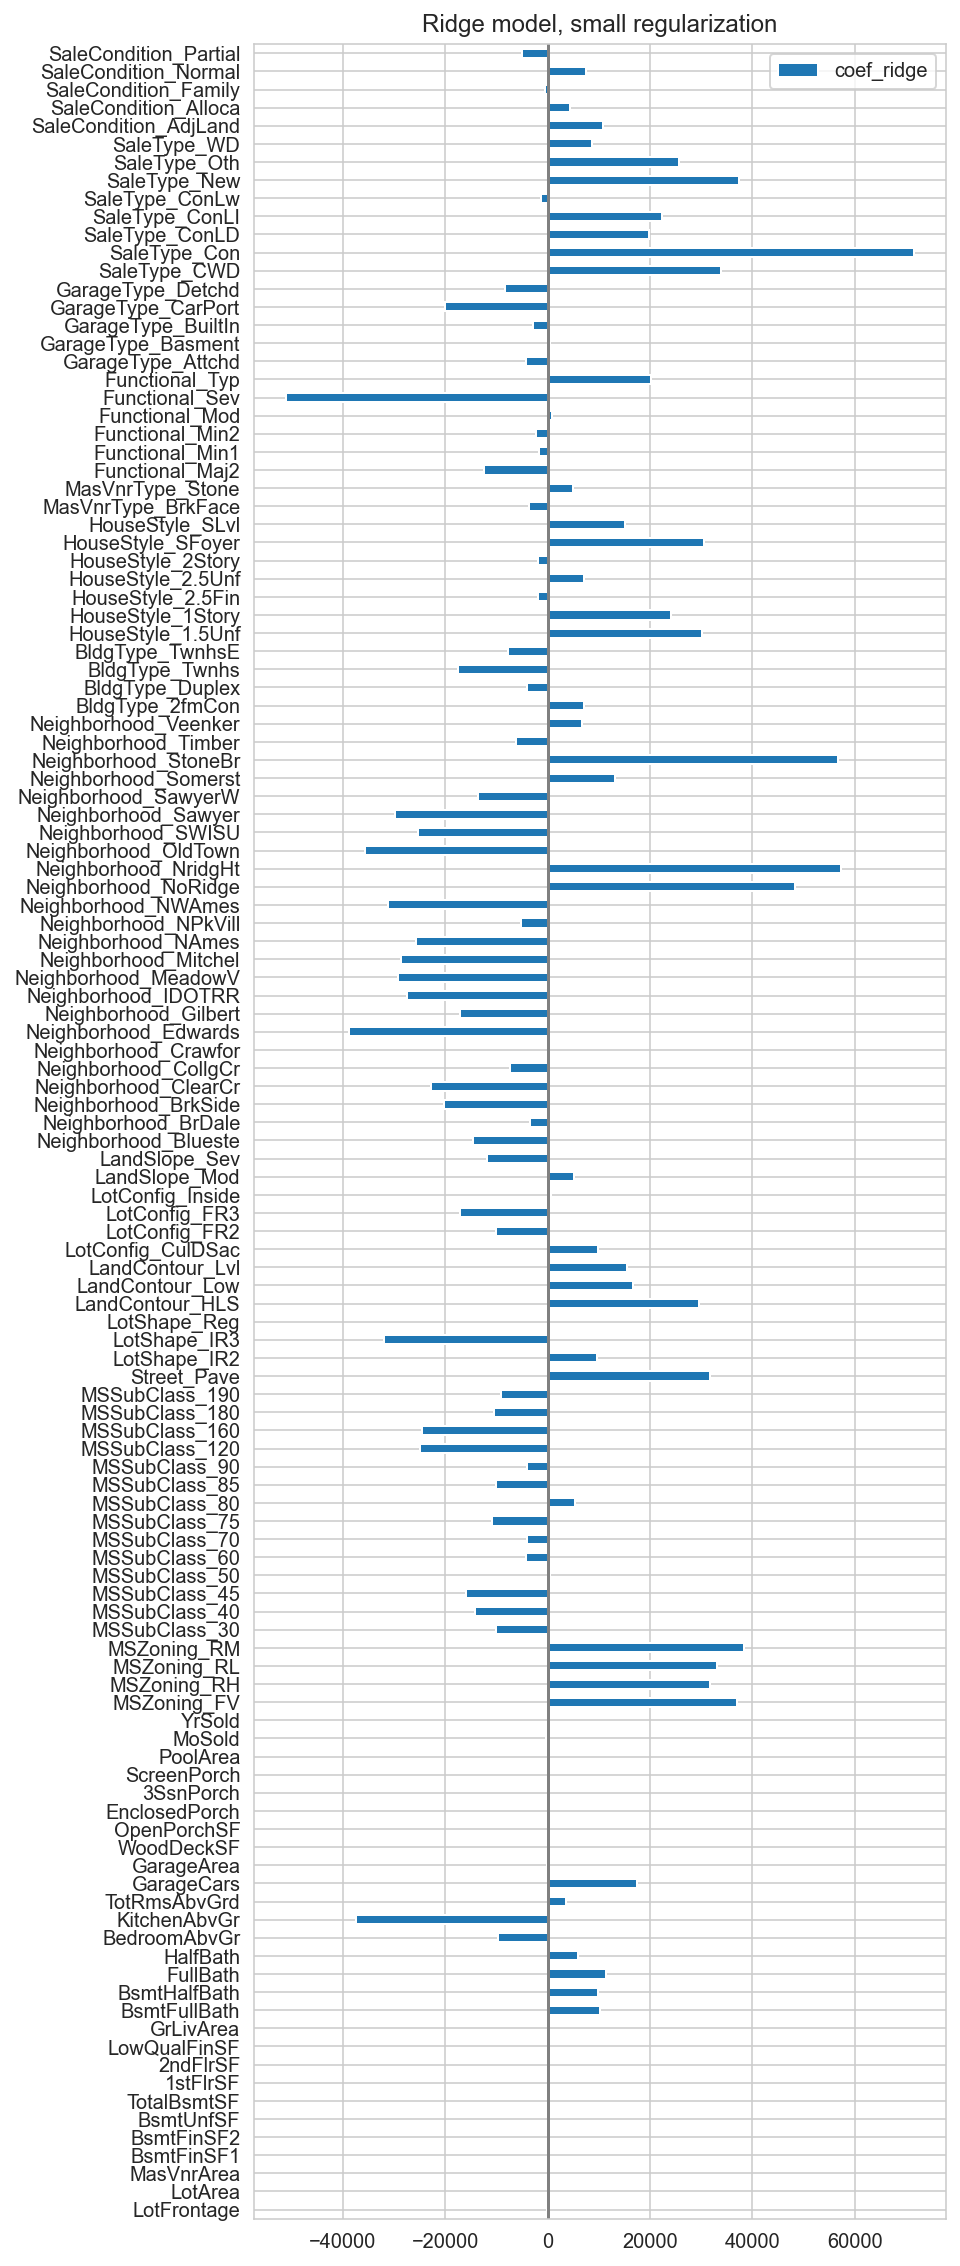

In [61]:
# Lets visualise the features which are highly important

ridge_data.plot(kind='barh', figsize=(8, 20))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [62]:
# Lets also try the score and feature with Lasso Regression


model_lasso = Lasso(alpha=0.1)

model_lasso.fit(X_train_df, y_train) 

pred_train_lasso = model_lasso.predict(X_train_df)

#print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print('Training_Score = ',r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test_df)
#print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print('Testing_Score = ',r2_score(y_test, pred_test_lasso))

Training_Score =  0.8436970899126846
Testing_Score =  0.8608335640629532


/Users/shamshersingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20728152304.603638, tolerance: 807923810.4946994
  positive)


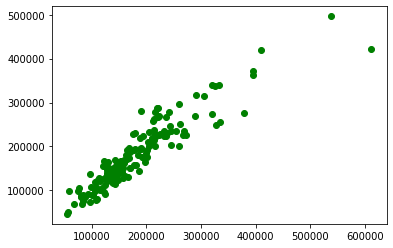

In [58]:
plt.scatter(y_test,pred_test_lasso,color='g')

In [63]:
Lasso_data = pd.DataFrame(model_lasso.coef_,index = X_test_df.columns , columns = ['coef_lasso'])# Print coefficients
Lasso_data.sort_values(by='coef_lasso')

coef_lasso
Functional_Sev        -58141.406459
Neighborhood_Edwards  -41171.822484
Neighborhood_OldTown  -38336.057105
KitchenAbvGr          -37499.937659
Neighborhood_NWAmes   -33312.883877
LotShape_IR3          -32342.297855
Neighborhood_Sawyer   -32271.951164
Neighborhood_MeadowV  -31700.336053
Neighborhood_Mitchel  -30980.512010
Neighborhood_IDOTRR   -29793.888799
Neighborhood_NAmes    -27910.249499
Neighborhood_SWISU    -27775.094892
MSSubClass_120        -26631.531404
MSSubClass_160        -26347.198110
Neighborhood_ClearCr  -25179.202099
Neighborhood_BrkSide  -22955.804822
Neighborhood_Gilbert  -19253.033810
GarageType_CarPort    -19090.676736
MSSubClass_45         -18785.818238
LotConfig_FR3         -17550.012916
Neighborhood_Blueste  -17141.462391
BldgType_Twnhs        -16428.543962
MSSubClass_90         -15990.831089
Neighborhood_SawyerW  -15815.973789
MSSubClass_40         -14748.060060
Functional_Maj2       -13322.855678
MSSubClass_75         -12577.256863
MSSubClass_180        -12479.773568
LandSlope_Sev         -12206.907184
MSSubClass_190        -11092.442417
MSSubClass_85         -11008.811951
LotConfig_FR2         -10143.674580
MSSubClass_30         -10028.230877
BedroomAbvGr           -9693.125980
Neighborhood_CollgCr   -9541.441635
GarageType_Detchd      -8302.298658
Neighborhood_Timber    -8294.179706
SaleCondition_Partial  -6932.126969
BldgType_TwnhsE        -6915.598206
Neighborhood_NPkVill   -6867.485590
Neighborhood_BrDale    -5615.853261
MSSubClass_60          -4766.946354
MSSubClass_70          -4479.789692
GarageType_Attchd      -4276.128996
MasVnrType_BrkFace     -3693.975015
GarageType_BuiltIn     -2885.624894
Functional_Min2        -2774.827497
Neighborhood_Crawfor   -2291.290437
Functional_Min1        -2146.584290
HouseStyle_2Story       -786.602085
SaleType_ConLw          -641.401489
SaleCondition_Family    -623.639604
MoSold                  -311.432578
HouseStyle_2.5Fin       -167.441266
LotFrontage             -119.002846
GarageArea               -18.059616
LotShape_Reg             -16.407782
LotArea                    0.397107
EnclosedPorch              0.528083
PoolArea                   2.804121
TotalBsmtSF                3.280806
BsmtUnfSF                  5.245528
GrLivArea                  7.973355
BsmtFinSF2                10.786736
BsmtFinSF1                12.727087
MasVnrArea                15.048026
OpenPorchSF               17.925825
WoodDeckSF                26.427134
LowQualFinSF              38.480143
3SsnPorch                 46.646501
1stFlrSF                  53.688040
2ndFlrSF                  67.958623
ScreenPorch               72.800393
YrSold                   189.396073
Functional_Mod           489.284339
GarageType_Basment       660.512157
LotConfig_Inside         769.758040
MSSubClass_50           1043.230686
TotRmsAbvGrd            3590.088661
Neighborhood_Veenker    3759.022952
SaleCondition_Alloca    4028.734434
MSSubClass_80           4818.518416
MasVnrType_Stone        4829.169785
LandSlope_Mod           5111.049563
HalfBath                5889.907810
SaleCondition_Normal    7272.768296
BldgType_Duplex         7649.492040
BldgType_2fmCon         8831.772640
SaleType_WD             9353.321578
HouseStyle_2.5Unf       9570.439480
LotShape_IR2            9588.711984
LotConfig_CulDSac       9624.479705
BsmtHalfBath            9859.756080
BsmtFullBath           10190.993908
SaleCondition_AdjLand  10702.187769
Neighborhood_Somerst   11043.292950
FullBath               11352.207315
LandContour_Lvl        15785.610124
HouseStyle_SLvl        16177.066559
GarageCars             17265.297375
LandContour_Low        17320.474886
Functional_Typ         19779.063928
SaleType_ConLD         21725.741927
SaleType_ConLI         23370.844325
HouseStyle_1Story      24782.408645
SaleType_Oth           26953.270648
LandContour_HLS        29958.583042
HouseStyle_SFoyer      31926.477581
Street_Pave            32350.644067
HouseStyle_1.5Unf      33593.193915
MSZoning_RH            34633.

In [64]:
print('Intercept:', model_lasso.intercept_)

Intercept: -422269.7744216926


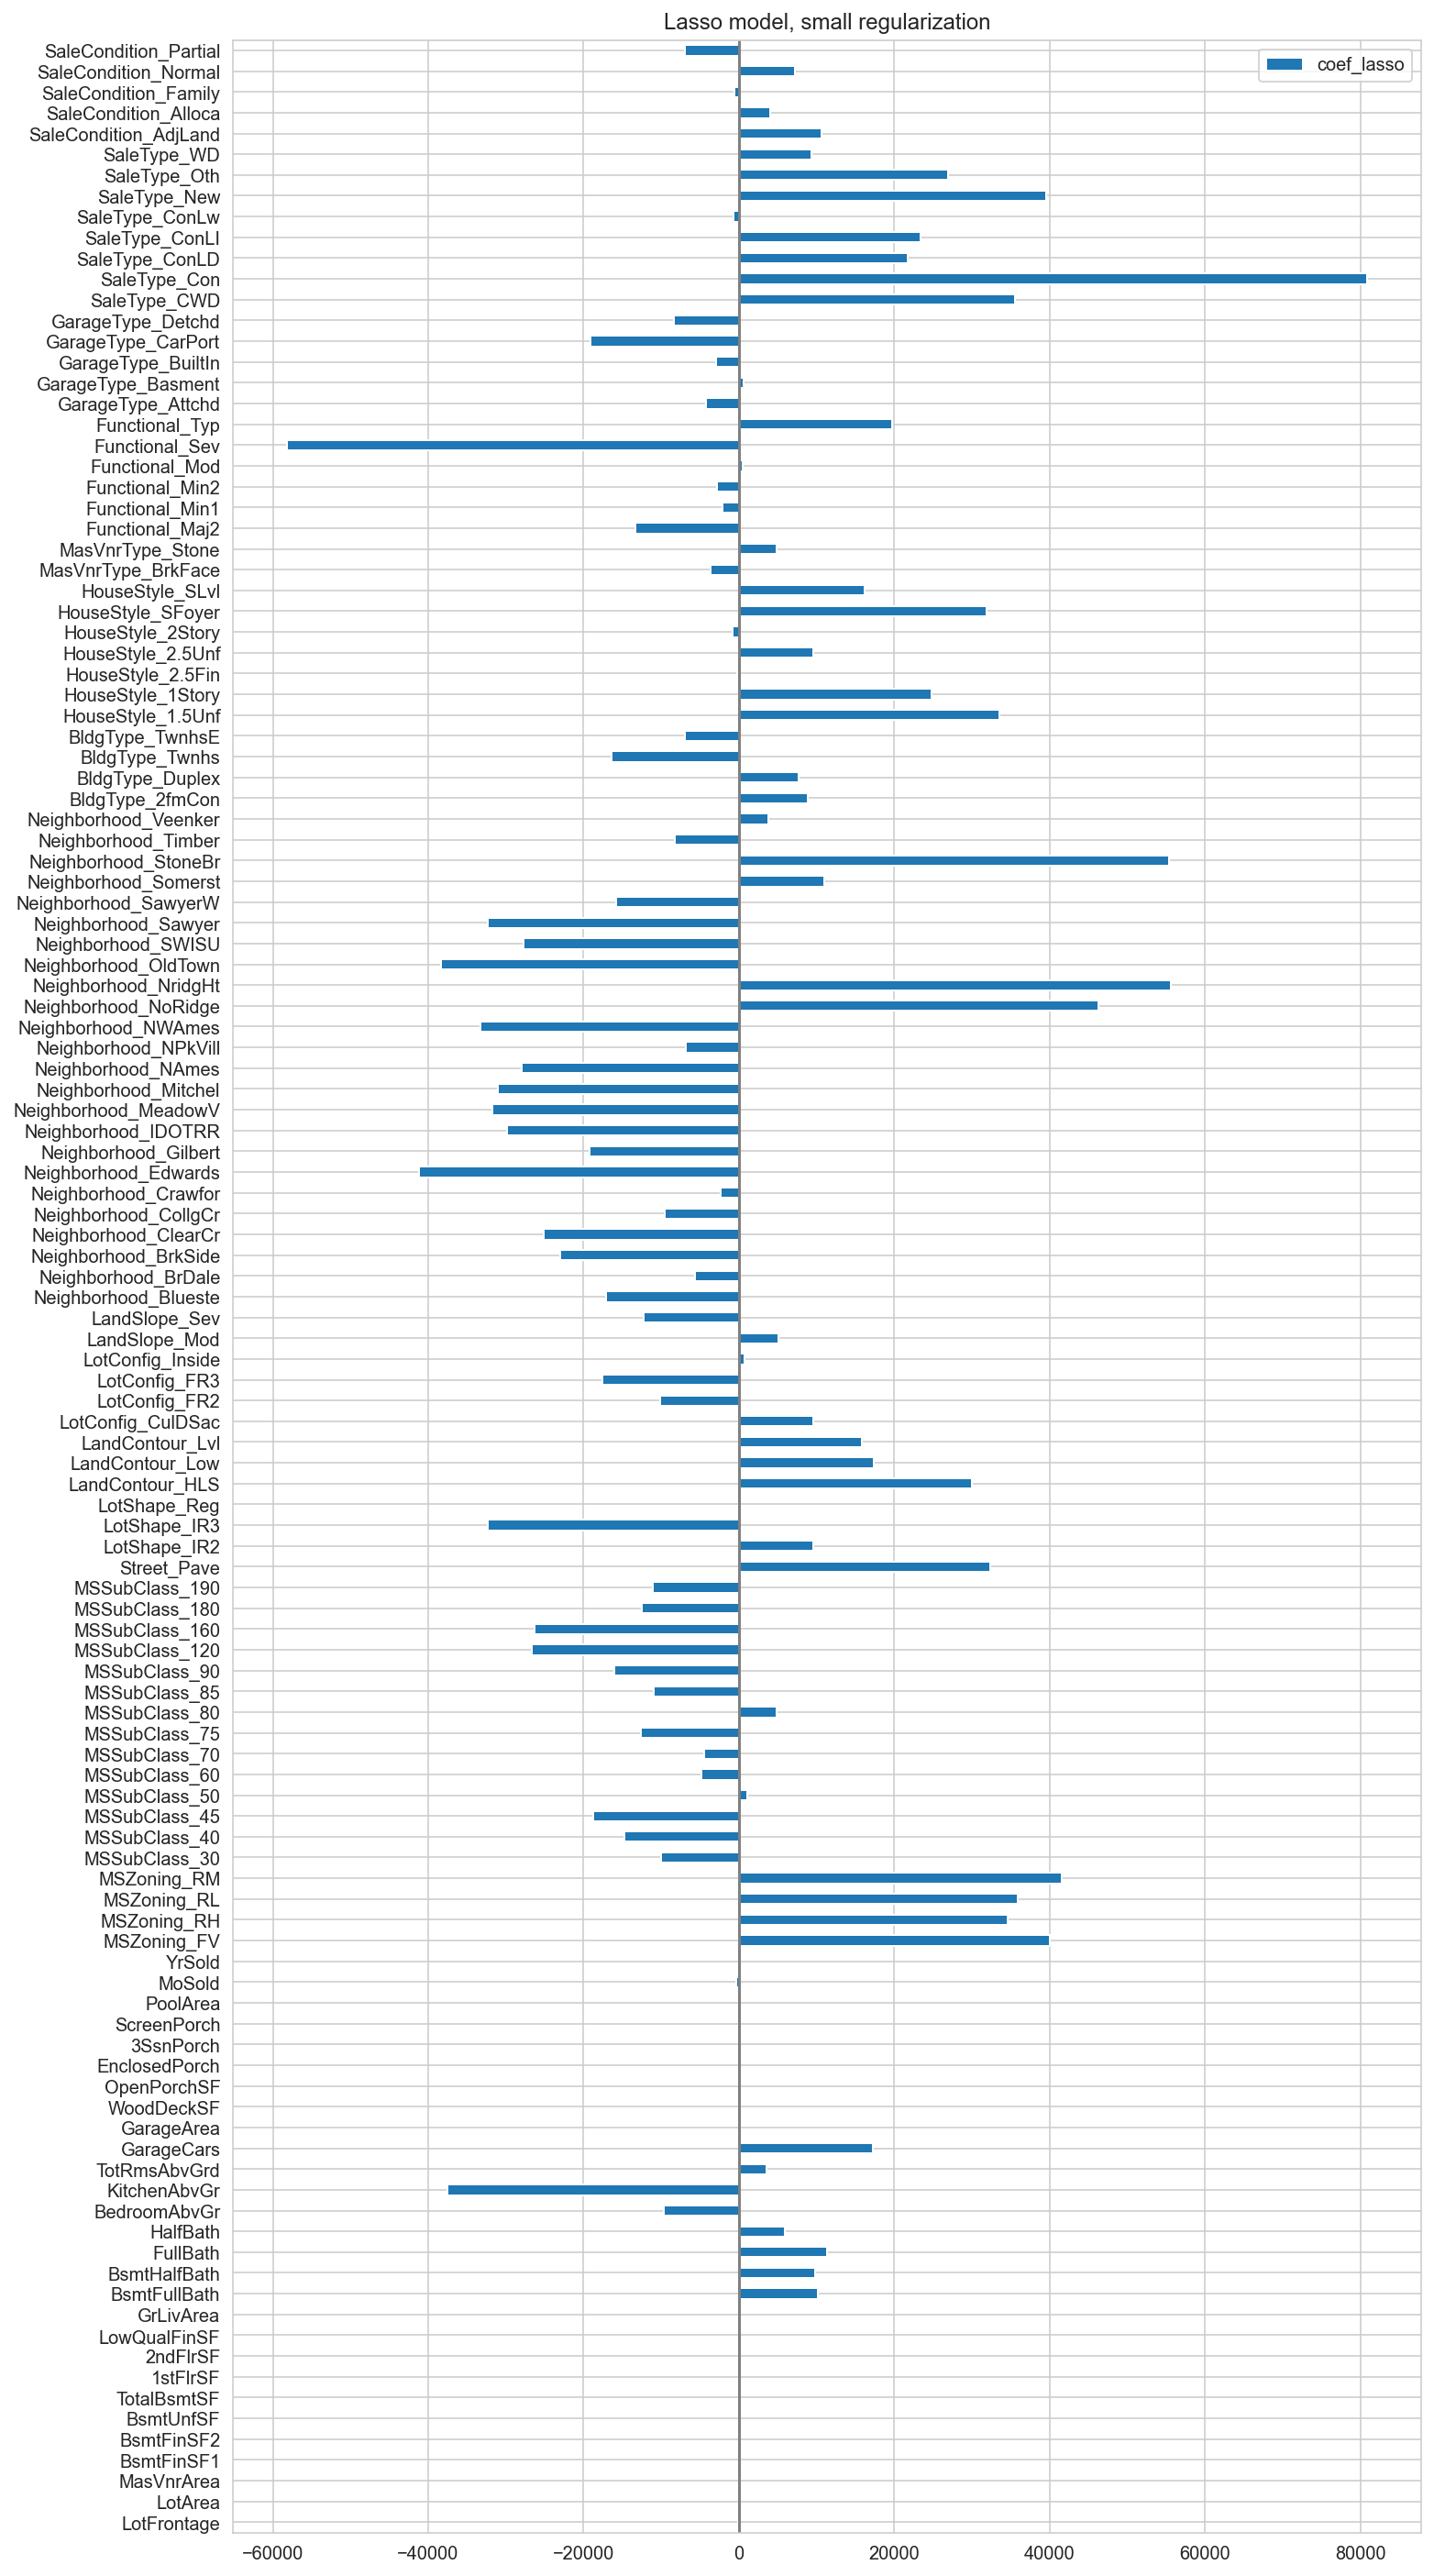

In [65]:
Lasso_data.plot(kind='barh', figsize=(15, 25))
plt.title('Lasso model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [66]:
fixed_df.head(2)

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0         65.0     8450       196.0         706           0        150   
1         80.0     9600         0.0         978           0        284   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0          856       856       854             0       1710             1   
1         1262      1262         0             0       1262             0   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
0             0         2         1             3             1             8   
1             1         2         0             3             1             6   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0           2         548           0           61              0          0   
1           2         460         298            0              0          0   

   ScreenPorch  PoolArea  MoSold  YrSold  SalePrice  MSZoning_FV  MSZoning_RH  \
0            0         0       2    2008     208500            0            0   
1            0         0       5    2007     181500            0            0   

   MSZoning_RL  MSZoning_RM  MSSubClass_30  MSSubClass_40  MSSubClass_45  \
0            1            0              0              0              0   
1            1            0              0              0              0   

   MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  \
0              0              1              0              0              0   
1              0              0              0              0              0   

   MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_160  \
0              0              0               0               0   
1              0              0               0               0   

   MSSubClass_180  MSSubClass_190  Street_Pave  LotShape_IR2  LotShape_IR3  \
0               0               0            1             0             0   
1               0               0            1             0             0   

   LotShape_Reg  LandContour_HLS  LandContour_Low  LandContour_Lvl  \
0             1                0                0                1   
1             1                0                0                1   

   LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  \
0                  0              0              0                 1   
1                  0              1              0                 0   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blueste  Neighborhood_BrDale  \
0              0              0                     0                    0   
1              0              0                     0                    0   

   Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  \
0                     0                     0                     1   
1                     0                     0                     0   

   Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
0                     0                     0                     0   
1                     0                     0                     0   

   Neighborhood_IDOTRR  Neighborhood_MeadowV  Neighborhood_Mitchel  \
0                    0                     0                     0   
1                    0                     0                     0   

   Neighborhood_NAmes  Neighborhood_NPkVill  Neighborhood_NWAmes  \
0                   0                     0                    0   
1                   0                     0                    0   

   Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  \
0                     0                     0                     0   
1                     0                     0                     0   

   Neighborhood_SWISU  Neighborhood_Sawyer  Neighborhood_SawyerW  \
0                   0                    0                     0   
1                   0                    0             

In [67]:
#Tried Lasso Model with new dataset after selecting new features

training_set = fixed_df[fixed_df['YrSold'] < 2010]
test_set = fixed_df[fixed_df['YrSold'] == 2010]
    

X_train_df_lasso = training_set.drop(columns=['SalePrice','SaleCondition_Family','SaleType_ConLw','GarageType_Basment',
            'Functional_Mod','HouseStyle_2Story','HouseStyle_2.5Fin','LotConfig_Inside','LotShape_Reg',
                                        'MSSubClass_50','GarageArea','WoodDeckSF',
'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold','YrSold','LotFrontage','LotArea',
                                        'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
'1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','YrSold'],axis=1)
y_train_lasso = training_set['SalePrice'].values
    
X_test_df_lasso = test_set.drop(columns=['SalePrice','SaleCondition_Family','SaleType_ConLw','GarageType_Basment',
            'Functional_Mod','HouseStyle_2Story','HouseStyle_2.5Fin','LotConfig_Inside','LotShape_Reg',
                                        'MSSubClass_50','GarageArea','WoodDeckSF',
'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold','YrSold','LotFrontage','LotArea',
                                        'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
'1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','YrSold'],axis=1)
y_test_lasso = test_set['SalePrice'].values

In [70]:
# Lets train and test the Lasso Model with new features

model_lasso_new = Lasso(alpha=0.1)

model_lasso_new.fit(X_train_df_lasso, y_train_lasso) 

pred_train_lasso = model_lasso_new.predict(X_train_df_lasso)

#print(np.sqrt(mean_squared_error(y_train_lasso,pred_train_lasso)))
print('training_Score',r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso_new.predict(X_test_df_lasso)
#print(np.sqrt(mean_squared_error(y_test_lasso,pred_test_lasso))) 
print('Testing score',r2_score(y_test_lasso, pred_test_lasso))

training_Score 0.7929936062695799
Testing score 0.8016953718974267


/Users/shamshersingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15281637110.9104, tolerance: 807923810.4946994
  positive)


In [69]:
Lasso_data_new = pd.DataFrame(model_lasso_new.coef_,index = X_train_df_lasso.columns ,columns =['coef_lasso_new'])# Print coefficients
Lasso_data_new.sort_values(by='coef_lasso_new')

coef_lasso_new
KitchenAbvGr            -52552.305223
MSSubClass_45           -44145.643638
MSSubClass_160          -35720.202334
LotConfig_FR3           -32479.299237
MSSubClass_120          -27930.796209
Functional_Sev          -25147.016461
MSSubClass_180          -23171.516533
MSSubClass_90           -22367.430916
GarageType_CarPort      -20908.542870
MSSubClass_30           -17361.679987
Neighborhood_Gilbert    -17123.563499
Neighborhood_Edwards    -16959.117081
LotConfig_FR2           -16704.409713
Functional_Maj2         -16233.945456
BldgType_Twnhs          -15917.579451
Neighborhood_NWAmes     -15428.048559
GarageType_Detchd       -14260.722809
MSSubClass_85           -13931.050621
SaleCondition_Partial   -12831.374204
Neighborhood_OldTown    -12785.443423
Neighborhood_Sawyer     -12766.323770
BedroomAbvGr            -11967.351187
Neighborhood_Mitchel    -11007.921285
MSSubClass_60           -10909.849032
Neighborhood_IDOTRR     -10760.865408
Functional_Min2         -10570.306346
Functional_Min1          -9604.432635
Neighborhood_MeadowV     -9320.655429
Neighborhood_SWISU       -7482.132240
SaleCondition_AdjLand    -7384.938801
Neighborhood_NAmes       -6596.792886
Neighborhood_NPkVill     -5169.302301
HouseStyle_2.5Unf        -5005.295549
MSSubClass_70            -4240.667156
GarageType_Attchd        -3791.509917
Neighborhood_Blueste     -2951.897456
HouseStyle_SLvl          -2441.924407
BldgType_2fmCon          -2399.628979
BldgType_TwnhsE          -1024.944154
MSSubClass_40              941.432389
LotShape_IR3              1049.483917
Neighborhood_BrkSide      1438.892616
Neighborhood_CollgCr      2499.564719
Neighborhood_SawyerW      2769.914187
Neighborhood_BrDale       2976.303593
GarageType_BuiltIn        3129.607131
MasVnrType_BrkFace        3194.315616
SaleCondition_Alloca      3895.298690
MSSubClass_80             5117.305434
SaleCondition_Normal      5393.177631
MSSubClass_190            6044.604541
BldgType_Duplex           6144.059446
LandContour_Lvl           7492.218713
Neighborhood_ClearCr      7625.414161
SaleType_WD               8451.579263
LandSlope_Mod             9445.137863
Functional_Typ            9960.665165
MSSubClass_75            10314.918141
SaleType_ConLD           10396.052759
HouseStyle_1Story        10813.911760
MasVnrType_Stone         10885.885895
LandContour_Low          12159.320631
LandSlope_Sev            12185.621335
Neighborhood_Timber      13433.459991
HouseStyle_SFoyer        13667.021989
LotConfig_CulDSac        13688.516474
TotRmsAbvGrd             15975.366565
BsmtHalfBath             16504.790566
LandContour_HLS          16595.235028
HalfBath                 18478.114024
GarageCars               19723.866012
Street_Pave              19784.022138
BsmtFullBath             20333.980360
LotShape_IR2             20466.693590
Neighborhood_Somerst     22405.579622
SaleType_ConLI           22629.169654
Neighborhood_Crawfor     28454.464198
SaleType_Oth             29108.190399
FullBath                 31266.993888
MSZoning_RL              32143.249573
MSZoning_RH              34494.003780
Neighborhood_Veenker     36227.122231
MSZoning_FV              37878.980742
HouseStyle_1.5Unf        39321.733491
MSZoning_RM              40269.704942
SaleType_CWD             43794.458432
SaleType_New             44102.688420
Neighborhood_NridgHt     73885.415701
SaleType_Con             78935.932392
Neighborhood_StoneBr     82363.092421
Neighborhood_NoRidge     98650.317494

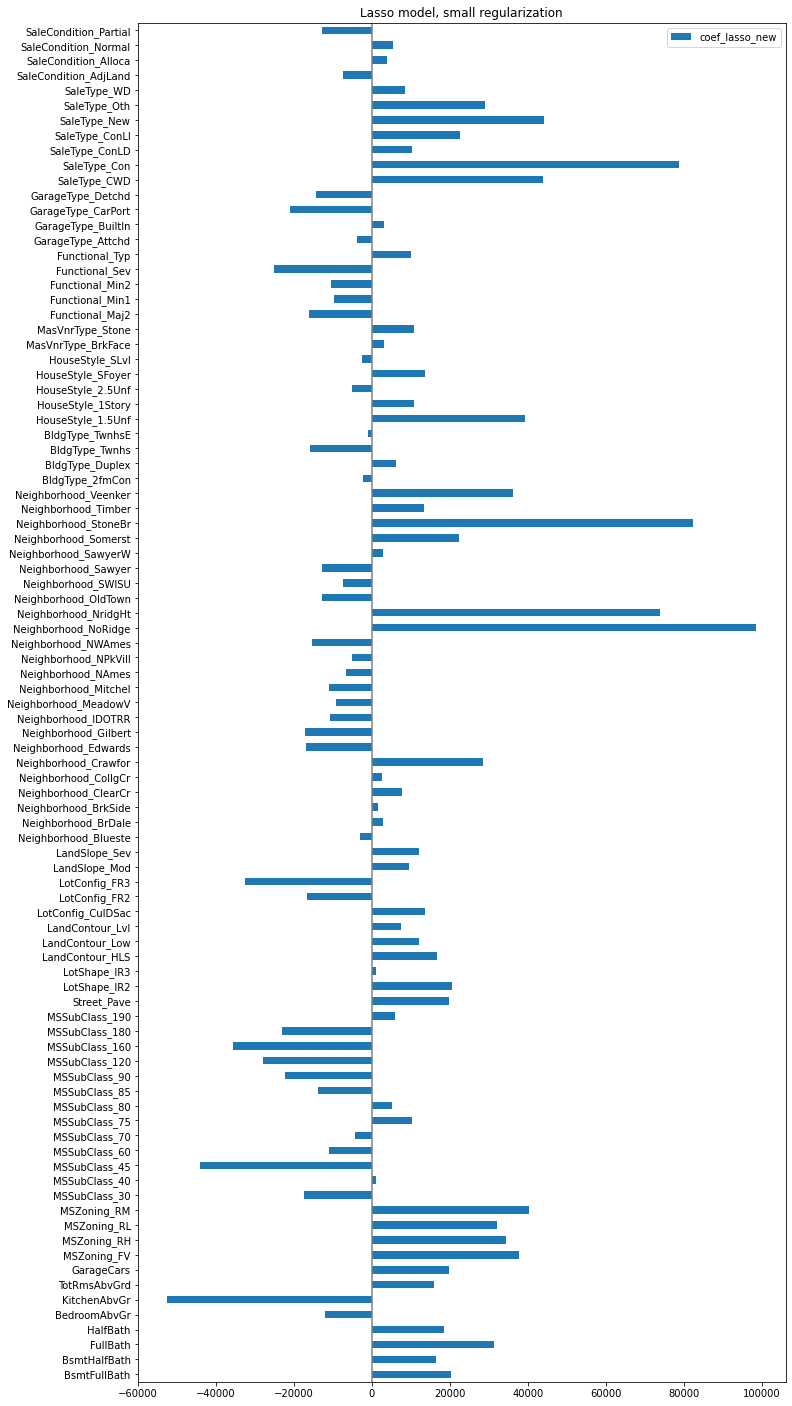

In [66]:
Lasso_data_new.plot(kind='barh', figsize=(15, 25))
plt.title('Lasso model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [68]:
# Renovatable = 'Condition1','Condition2','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st',
# 'Exterior2nd','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
# 'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Fireplaces',
# 'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','MiscFeature','MiscVal',

In [69]:
house.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0     2Story            7            5       2003          2003     Gable   
1     1Story            6            8       1976          1976     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA   
1  CompShg     MetalSd     MetalSd       None         0.0        TA        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0      PConc       Gd       TA           No          GLQ         706   
1     CBlock       Gd       TA           Gd          ALQ         978   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
0          Unf           0        150          856    GasA        Ex   
1          Unf           0        284         1262    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr       856       854             0       1710   
1          Y      SBrkr      1262         0             0       1262   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0             1             0         2         1             3             1   
1             0             1         2         0             3             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces   FireplaceQu GarageType  \
0          Gd             8        Typ           0  No_Fireplace     Attchd   
1          TA             6        Typ           1            TA     Attchd   

   GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond  \
0       2003.0          RFn           2         548         TA         TA   
1       1976.0          RFn           2         460         TA         TA   

  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0          Y           0           61              0          0            0   
1          Y         298            0              0          0            0   

   PoolArea  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice  
0         0        0       2    2008       WD        Normal     208500  
1         0        0       5    2007       WD        Normal     181500

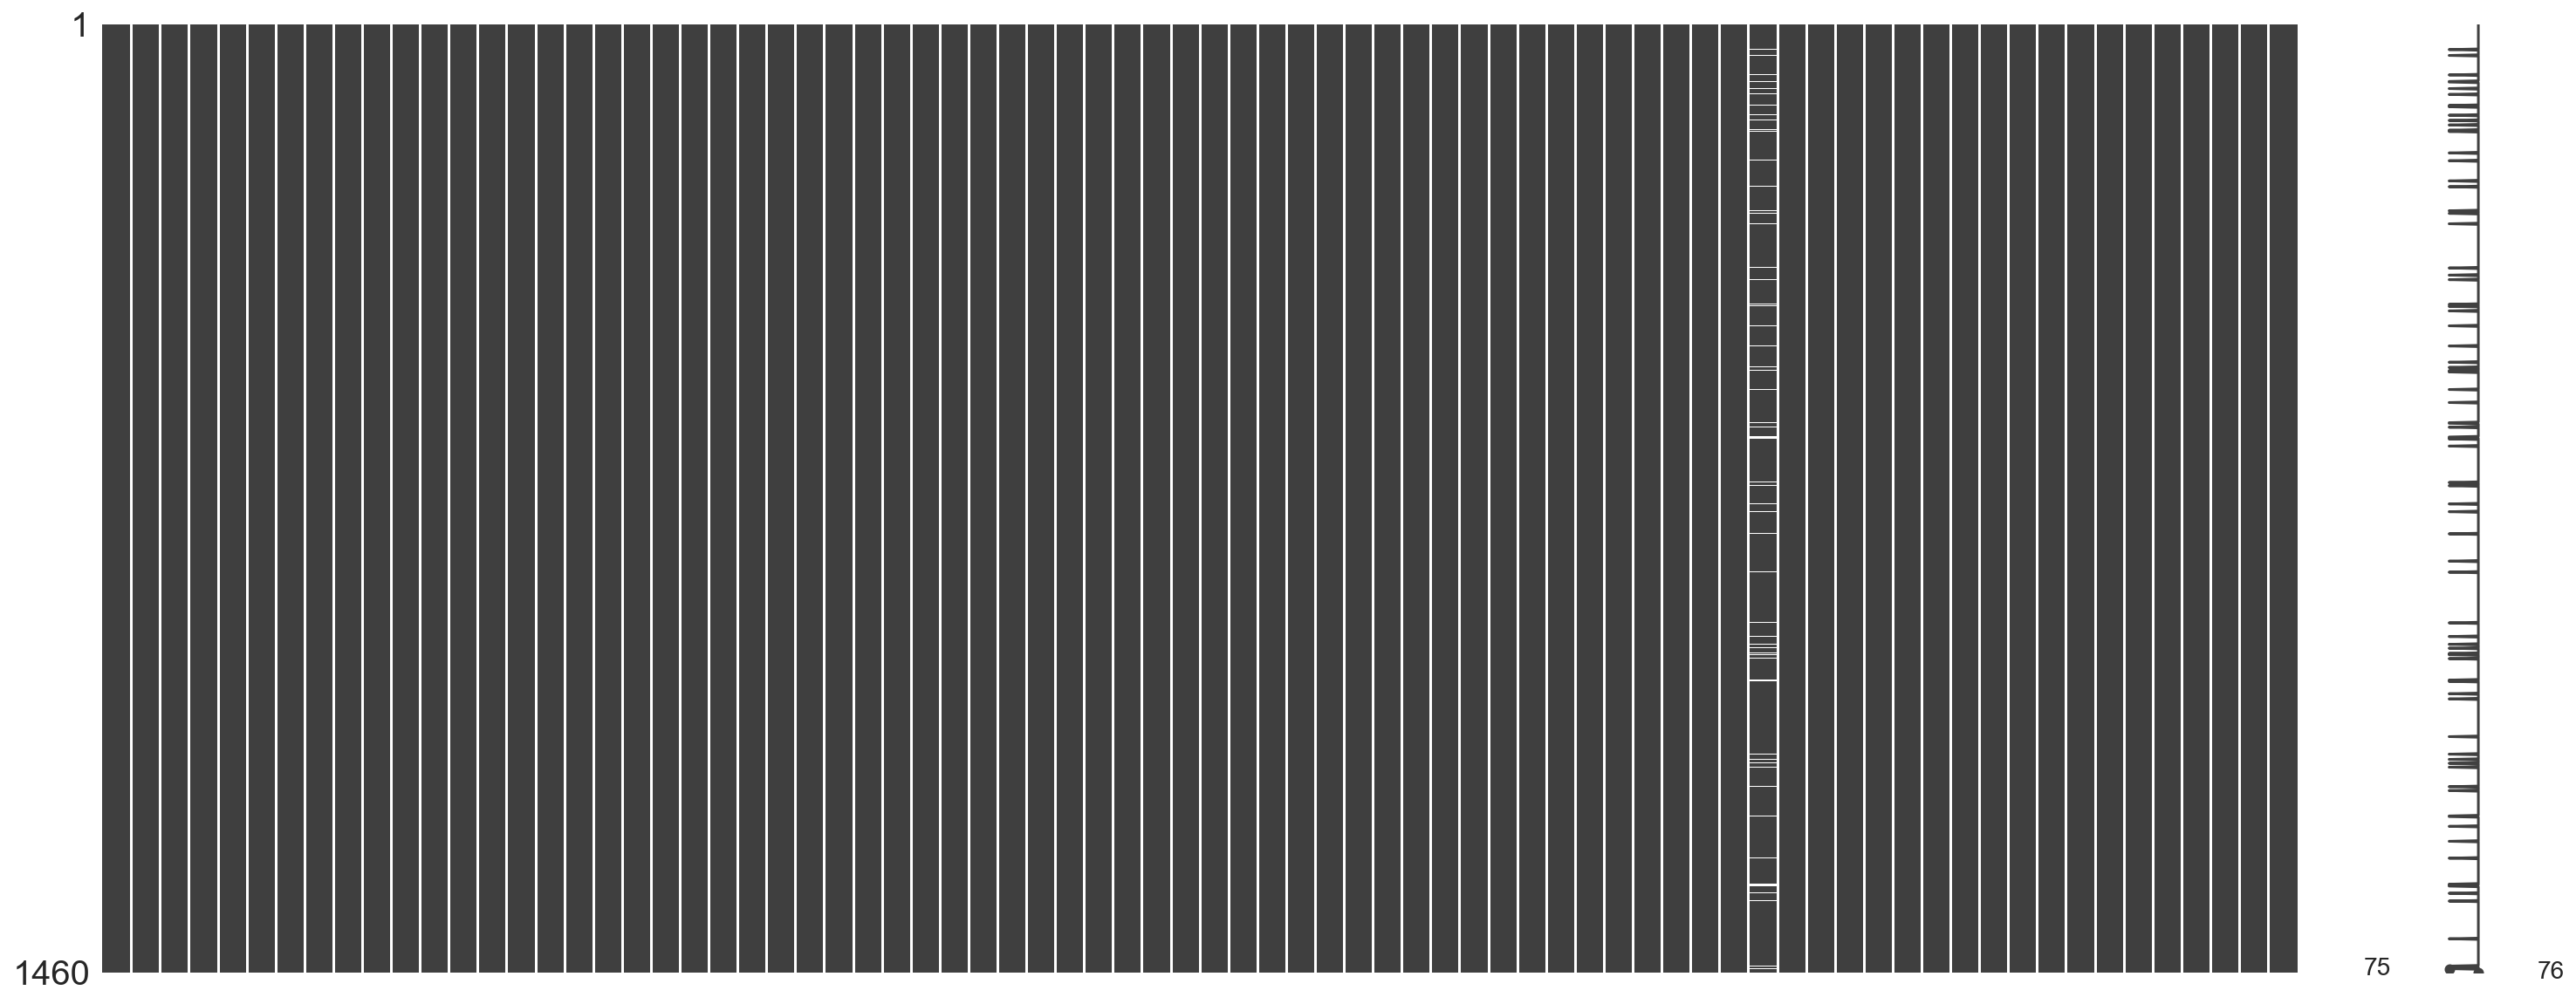

In [71]:
# lets visualise the missing values in rennovate datasets

import missingno as msno
msno.matrix(house)

In [72]:
null_val = house.columns[house.isna().any()]
house[null_val].isnull().sum()

GarageYrBlt    81
dtype: int64

In [74]:
# Lets get dummies of the catagorical features

renovate = pd.get_dummies(data = house , columns =['Condition1','Condition2','RoofStyle','RoofMatl','Exterior1st',
                                                  'Exterior2nd','ExterQual','ExterCond','Foundation','BsmtQual',
'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical',
'KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive',],drop_first=True)
renovate.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   

  Utilities LotConfig LandSlope Neighborhood BldgType HouseStyle  OverallQual  \
0    AllPub    Inside       Gtl      CollgCr     1Fam     2Story            7   
1    AllPub       FR2       Gtl      Veenker     1Fam     1Story            6   

   OverallCond  YearBuilt  YearRemodAdd MasVnrType  MasVnrArea  BsmtFinSF1  \
0            5       2003          2003    BrkFace       196.0         706   
1            8       1976          1976       None         0.0         978   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0           0        150          856       856       854             0   
1           0        284         1262      1262         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   

   KitchenAbvGr  TotRmsAbvGrd Functional  Fireplaces GarageType  GarageYrBlt  \
0             1             8        Typ           0     Attchd       2003.0   
1             1             6        Typ           1     Attchd       1976.0   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0           2         548           0           61              0          0   
1           2         460         298            0              0          0   

   ScreenPorch  PoolArea  MiscVal  MoSold  YrSold SaleType SaleCondition  \
0            0         0        0       2    2008       WD        Normal   
1            0         0        0       5    2007       WD        Normal   

   SalePrice  Condition1_Feedr  Condition1_Norm  Condition1_PosA  \
0     208500                 0                1                0   
1     181500                 1                0                0   

   Condition1_PosN  Condition1_RRAe  Condition1_RRAn  Condition1_RRNe  \
0                0                0                0                0   
1                0                0                0                0   

   Condition1_RRNn  Condition2_Feedr  Condition2_Norm  Condition2_PosA  \
0                0                 0                1                0   
1                0                 0                1                0   

   Condition2_PosN  Condition2_RRAe  Condition2_RRAn  Condition2_RRNn  \
0                0                0                0                0   
1                0                0                0                0   

   RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  \
0                1                  0              0                  0   
1                1                  0              0                  0   

   RoofStyle_Shed  RoofMatl_CompShg  RoofMatl_Membran  RoofMatl_Metal  \
0               0                 1                 0               0   
1               0                 1                 0               0   

   RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  RoofMatl_WdShngl  \
0              0                 0                 0                 0   
1              0                 0                 0                 0   

   Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  \
0                    0                    0                    0   
1                    0                    0                    0   

   Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  \
0                   0                    0                    0   
1                   0                    0                    0   

   Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  \
0                    0                    0                    0   
1                    0                    1

In [75]:
# lets check the shape

renovate.shape

(1460, 182)

In [78]:
# Lets remove the fixed columns from the rennovate datasets

predictors = [c for c in renovate.columns if c not in['BsmtQual_No Basement','BsmtCond_No Basement','BsmtExposure_No'
                                                    'BsmtExposure_No Basement','BsmtFinType1_No Basement',
'BsmtFinType2_No Basement','FireplaceQu_No_Fireplace','GarageFinish_No Garage','GarageQual_No Garage',
                                                   'GarageCond_No Garage','MSSubClass','MSZoning','LotFrontage',
'LotArea','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','BldgType',
'HouseStyle','YearBuilt','YearRemodAdd','MasVnrType','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath',
'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Functional','GarageType', 'GarageYrBlt','GarageCars',
'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold',
                                                   'SaleType','SaleCondition']]  

In [79]:
# lets make a dataframe now

renovate_df = renovate[predictors]
renovate_df.columns

Index(['OverallQual', 'OverallCond', 'Fireplaces', 'MiscVal', 'YrSold',
       'SalePrice', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA',
       'Condition1_PosN',
       ...
       'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA',
       'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA',
       'PavedDrive_P', 'PavedDrive_Y'],
      dtype='object', length=128)

In [80]:
# Lets split the data into Train and Test

training_set = renovate_df[renovate_df['YrSold'] < 2010]

test_set = renovate_df[renovate_df['YrSold'] == 2010]
    

X_train_reno = training_set.drop(columns=['SalePrice'],axis=1)

y_train_reno =  training_set['SalePrice'].values - prediction_on_train_set


    
X_test_reno = test_set.drop(columns=['SalePrice'],axis=1)

y_test_reno = test_set['SalePrice'].values - prediction_on_test_set

In [81]:
X_train_reno.shape

(1285, 127)

In [82]:
training_set = renovate_df[renovate_df['YrSold'] < 2010]
test_set = renovate_df[renovate_df['YrSold'] == 2010]
    

X_train_reno = training_set.drop(columns=['SalePrice'],axis=1)
y_train_reno =  training_set['SalePrice'].values - prediction_on_train_set
    

X_test_reno = test_set.drop(columns=['SalePrice'],axis=1)
y_test_reno = test_set['SalePrice'].values - prediction_on_test_set

In [83]:
# lets make a pipeline for Linearregression and try the score with it

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

ss = StandardScaler()

model = make_pipeline(StandardScaler(),LinearRegression())

model.fit(X_train_reno,y_train_reno)

yhat1 = model.predict(X_test_reno)

scores = model.score(X_test_reno,y_test_reno)
scores

-1.4764152196737776e+23

In [85]:
yhat1.max() , y_test.min()

(753851767971984.5, 55000)

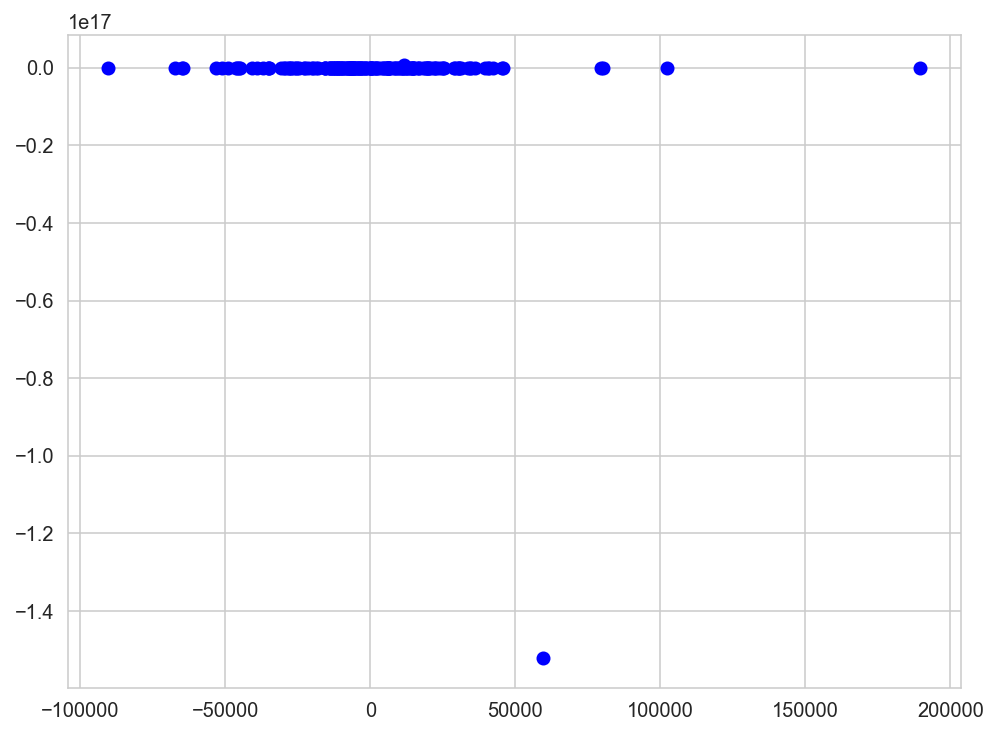

In [87]:
# Lets visualise the predictions

import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
plt.scatter(y_test_reno,yhat1, c = 'b')

In [88]:
data = pd.DataFrame(model[-1].coef_, index = X_train_reno.columns , columns = ['coef_lin'])

In [89]:
data.sort_values(by='coef_lin')

coef_lin
Exterior1st_CBlock       -8.417456e+15
RoofStyle_Shed           -4.241946e+15
ExterCond_Po             -6.996856e+13
GarageQual_TA            -1.440400e+04
GarageQual_Fa            -9.969000e+03
Condition2_PosN          -7.780665e+03
KitchenQual_Gd           -7.043547e+03
BsmtQual_Gd              -6.187250e+03
ExterQual_TA             -6.096188e+03
ExterQual_Gd             -5.805750e+03
KitchenQual_TA           -5.725625e+03
Exterior2nd_CmentBd      -4.795625e+03
Exterior1st_VinylSd      -4.775406e+03
GarageQual_Gd            -4.209531e+03
GarageQual_Po            -3.381625e+03
Exterior2nd_HdBoard      -3.042438e+03
BsmtQual_TA              -2.824656e+03
FireplaceQu_Gd           -2.821750e+03
GarageFinish_RFn         -2.414000e+03
Exterior2nd_Wd Shng      -2.317750e+03
KitchenQual_Fa           -1.752562e+03
Exterior1st_ImStucc      -1.694062e+03
FireplaceQu_TA           -1.657438e+03
Exterior2nd_Stone        -1.604703e+03
Exterior2nd_Plywood      -1.489500e+03
BsmtFinType2_BLQ         -1.477000e+03
BsmtFinType2_LwQ         -1.465625e+03
HeatingQC_Gd             -1.453625e+03
Condition2_Norm          -1.412094e+03
Heating_OthW             -1.142062e+03
HeatingQC_TA             -1.124125e+03
Condition2_Feedr         -1.076544e+03
BsmtExposure_No          -1.007867e+03
BsmtFinType2_Unf         -1.003562e+03
Exterior2nd_BrkFace      -9.972500e+02
Exterior2nd_Other        -9.617383e+02
BsmtFinType2_Rec         -8.247500e+02
Foundation_Wood          -7.022500e+02
ExterCond_Gd             -6.765000e+02
Foundation_Slab          -6.760938e+02
BsmtExposure_Mn          -6.644688e+02
Condition2_RRNn          -6.600976e+02
HeatingQC_Po             -6.483750e+02
HeatingQC_Fa             -6.461250e+02
BsmtFinType1_LwQ         -6.182500e+02
ExterCond_Fa             -6.142500e+02
Exterior1st_MetalSd      -4.807500e+02
YrSold                   -4.723433e+02
PavedDrive_P             -4.471250e+02
Electrical_other         -4.324375e+02
FireplaceQu_Fa           -3.710938e+02
Exterior2nd_Stucco       -3.554375e+02
BsmtQual_Fa              -3.445625e+02
Exterior2nd_Wd Sdng      -3.130000e+02
Exterior2nd_AsphShn      -2.477500e+02
Exterior2nd_Brk Cmn      -1.826250e+02
Exterior1st_Wd Sdng      -1.710625e+02
Exterior1st_Plywood      -1.273750e+02
BsmtFinType1_BLQ         -6.443750e+01
BsmtFinType1_Rec         -2.900000e+01
Condition1_RRAe           1.010088e+01
BsmtFinType1_Unf          2.137500e+01
Condition2_RRAn           5.258350e+01
Electrical_SBrkr          9.521875e+01
ExterQual_Fa              1.145000e+02
Foundation_Stone          1.592344e+02
ExterCond_TA              1.948125e+02
BsmtFinType2_GLQ          1.960000e+02
MiscVal                   2.063310e+02
Condition1_RRNn           2.589141e+02
Electrical_FuseF          3.464375e+02
CentralAir_Y              3.791250e+02
PavedDrive_Y              3.828750e+02
Exterior2nd_MetalSd       4.112500e+02
Condition2_PosA           4.375530e+02
Exterior1st_Stone         4.780469e+02
FireplaceQu_Po            4.923750e+02
Exterior1st_Stucco        5.167500e+02
Condition1_RRNe           5.809553e+02
GarageFinish_Unf          6.323750e+02
BsmtCond_Po               6.498750e+02
Electrical_Mix            7.039375e+02
BsmtCond_Gd               7.168750e+02
Condition1_Feedr          7.206611e+02
RoofStyle_Mansard         7.898816e+02
Heating_Grav              8.406562e+02
BsmtExposure_No Basement  8.500625e+02
Exterior1st_BrkComm       8.616250e+02
Condition1_PosA           8.718368e+02
Exterior1st_WdShing       9.102500e+02
RoofStyle_Gambrel         9.565343e+02
Electrical_FuseP          1.038375e+03
Heating_GasW              1.040250e+03
BsmtFinType1_GLQ          1.181500e+03
Exterior1st_HdBoard       1.267500e+03
Heating_Wall              1.294250e+03
Condition1_PosN           1.299802e+03
RoofStyle_Hip             1.443310e+03
Fireplaces                1.539833e+03
Condition1_RRAn           1.863669e+03
BsmtCond_TA               1.893062e+03
RoofStyle_Gable           1.951289e+03
Exterior2nd_I

In [90]:
# Lets try with Ridge Model

from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

ridge = Ridge(alpha=.1)

ridge.fit(X_train_reno, y_train_reno)             # Fit a ridge regression on the training data

pred_test = ridge.predict(X_test_reno)           # Use this model to predict the test data

#print('mean_squared_error_test',np.sqrt(mean_squared_error(y_test_reno,pred_test)))
print('Testing score = ',ridge.score(X_test_reno,y_test_reno))
      
pred_train = ridge.predict(X_train_reno) 
      
#print('mean_squared_error_train',np.sqrt(mean_squared_error(y_train_reno,pred_train)))  
print('Training score =',ridge.score(X_train_reno,y_train_reno))

Testing score =  0.21374773402498626
Training score = 0.3484484693387724


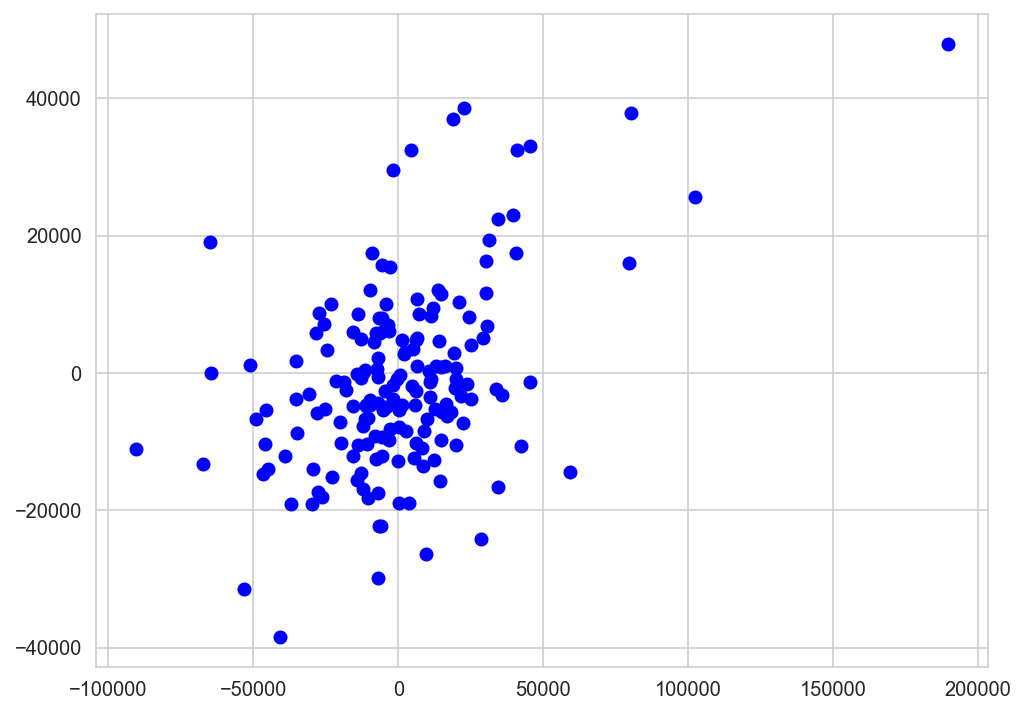

In [91]:
plt.figure(figsize = (8,6))
plt.scatter(y_test_reno,pred_test, c = 'b')

In [95]:
# Top coef with Ridge 

data_ridge = pd.DataFrame(ridge.coef_ , index = X_train_reno.columns , columns = ['coef_Ridge'])
data_ridge.sort_values(by='coef_Ridge')

coef_Ridge
Condition2_PosN          -173496.459838
Exterior1st_ImStucc       -56976.042886
GarageQual_Po             -42041.522238
Heating_OthW              -33518.775221
GarageQual_Fa             -32322.759930
Exterior2nd_Other         -29277.294329
GarageQual_TA             -25795.555333
RoofStyle_Hip             -24448.963301
RoofStyle_Gable           -23514.483489
Exterior2nd_Stone         -23280.535324
HeatingQC_Po              -21047.809625
GarageQual_Gd             -17889.476945
Foundation_Wood           -17347.595998
RoofStyle_Gambrel         -17325.836694
Exterior2nd_CmentBd       -16877.147171
Condition2_RRAe           -14967.196819
RoofStyle_Shed            -14967.196819
Electrical_other          -14490.373361
KitchenQual_Gd            -14203.092843
Exterior2nd_Wd Shng       -12753.038731
BsmtQual_Gd               -12447.222384
Exterior1st_VinylSd       -11685.359763
RoofStyle_Mansard         -11616.921306
KitchenQual_TA            -11192.406497
KitchenQual_Fa            -10799.690377
BsmtFinType2_BLQ           -9753.993215
ExterQual_TA               -8882.715894
ExterQual_Gd               -8509.745546
Exterior2nd_AsphShn        -7273.501927
Condition2_Feedr           -6910.983799
Exterior2nd_HdBoard        -6678.765127
BsmtFinType2_LwQ           -6597.149208
Foundation_Slab            -6403.536162
BsmtQual_TA                -5246.227571
Exterior2nd_CBlock         -5134.674884
Exterior1st_CBlock         -5134.674884
FireplaceQu_Gd             -5081.565274
GarageFinish_RFn           -5043.014228
Exterior2nd_Stucco         -4969.235074
Exterior1st_Stucco         -4387.063449
HeatingQC_Gd               -3999.852773
BsmtFinType2_Rec           -3986.478405
Exterior2nd_BrkFace        -3897.904384
HeatingQC_Fa               -3688.211677
Exterior1st_Wd Sdng        -3432.743917
Exterior2nd_Plywood        -3262.010839
Condition2_RRNn            -3107.711079
Exterior1st_MetalSd        -2931.698264
PavedDrive_P               -2803.194541
ExterCond_Fa               -2770.371692
HeatingQC_TA               -2686.105950
BsmtFinType1_LwQ           -2477.213231
FireplaceQu_TA             -2412.267487
Condition2_Norm            -2332.578241
BsmtExposure_No            -2117.942930
Exterior2nd_Brk Cmn        -2106.535705
ExterCond_Gd               -2067.155559
BsmtExposure_Mn            -1921.043948
BsmtFinType2_Unf           -1757.179462
Condition1_RRAe            -1686.194827
FireplaceQu_Fa             -1631.277373
Exterior1st_Plywood        -1449.306107
BsmtQual_Fa                -1043.266253
Condition1_Feedr           -1003.885241
Electrical_SBrkr            -717.694418
YrSold                      -456.747486
BsmtFinType1_BLQ            -376.612842
BsmtFinType1_Unf            -211.785612
Exterior1st_AsphShn            0.000000
ExterCond_Po                   0.000000
MiscVal                        0.354433
BsmtFinType1_Rec             410.582377
ExterCond_TA                 598.736154
Exterior1st_HdBoard         1044.953828
Exterior2nd_Wd Sdng         1185.557304
Fireplaces                  1315.892649
PavedDrive_Y                1600.099493
GarageFinish_Unf            1865.712229
Electrical_FuseF            1922.345501
CentralAir_Y                1986.153288
Exterior2nd_MetalSd         2092.648030
BsmtFinType1_GLQ            2568.308358
Foundation_Stone            2774.230833
Condition1_RRNn             3666.183650
Foundation_PConc            3762.061906
OverallQual                 3838.500960
BsmtCond_Gd                 4023.774359
Exterior1st_WdShing         4151.137443
Foundation_CBlock           4392.568225
FireplaceQu_Po              4767.358665
BsmtFinType2_GLQ            4841.430871
OverallCond                 5162.350817
ExterQual_Fa                5713.245859
BsmtCond_TA                 6651.943825
Heating_GasW                7084.326127
Heating_Grav                7525.987941
BsmtExposure_No Basement    7654.850937
BsmtExposure_Gd             8038.261980
GarageCond_Gd               8413.665435
Condition1_PosN             8

In [92]:
# Lets also see the score with Lasso Regression

model_lasso = Lasso(alpha=0.1)

model_lasso.fit(X_train_reno, y_train_reno) 

pred_train_lasso = model_lasso.predict(X_train_reno)
print('Training score =',r2_score(y_train_reno, pred_train_lasso))


pred_test_lasso= model_lasso.predict(X_test_reno)
print('Testing score = ',r2_score(y_test_reno, pred_test_lasso))

Training score = 0.37207922870304555
Testing score =  0.21394437132307154


/Users/shamshersingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302460967594.6327, tolerance: 126280460.29979415
  positive)


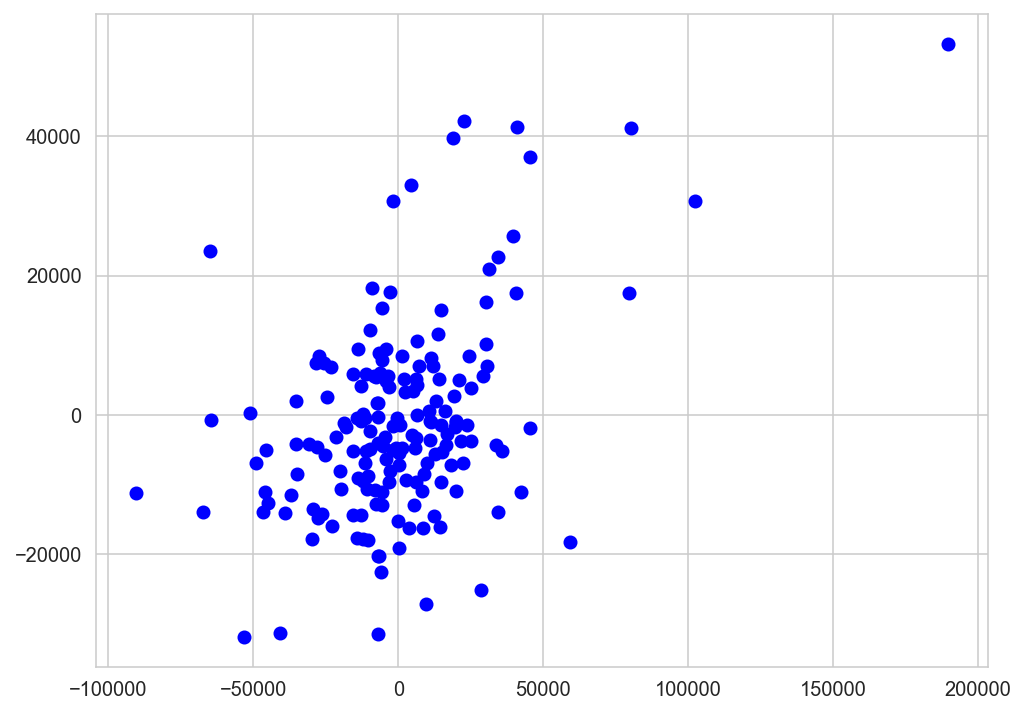

In [93]:
# Lets visualise the predictions

plt.figure(figsize = (8,6))
plt.scatter(y_test_reno,pred_test_lasso, c = 'b')

In [888]:
# Lets see the top coef with lasso

data_lasso = pd.DataFrame(model_lasso.coef_ , index = X_train_reno.columns , columns = ['coef_lasso'])
data_lasso.sort_values(by='coef_lasso')

coef_lasso
Condition2_PosN          -197416.268187
GarageQual_Po             -66603.116361
Exterior1st_ImStucc       -61030.143912
GarageQual_Fa             -50709.441598
GarageQual_TA             -44256.274437
GarageQual_Gd             -38241.589306
Exterior2nd_Other         -33839.165688
Heating_OthW              -30686.429460
Exterior2nd_Stone         -25613.344454
Exterior2nd_CmentBd       -24047.721812
HeatingQC_Po              -23010.883359
Foundation_Wood           -17373.383587
Condition2_Feedr          -16608.715332
Condition2_RRNn           -16390.975243
Condition2_RRAe           -16278.297264
Electrical_other          -15513.360183
Exterior2nd_Wd Shng       -14839.293445
KitchenQual_Gd            -14416.657235
Condition2_Norm           -12862.015912
BsmtQual_Gd               -12514.276161
ExterQual_TA              -12309.625752
ExterQual_Gd              -12041.542068
KitchenQual_TA            -11474.079166
KitchenQual_Fa            -10968.079750
BsmtFinType2_BLQ          -10453.685945
Exterior1st_VinylSd        -9798.748957
Exterior2nd_HdBoard        -8426.349845
BsmtFinType2_LwQ           -8169.587766
Exterior2nd_BrkFace        -7307.908777
Exterior1st_CBlock         -6767.147470
Exterior2nd_AsphShn        -6493.545369
FireplaceQu_Gd             -6476.160934
BsmtQual_TA                -5711.093649
Foundation_Slab            -5474.682475
GarageFinish_RFn           -5341.617164
ExterCond_Fa               -4901.022034
Exterior2nd_Plywood        -4821.527803
BsmtFinType2_Rec           -4630.172564
FireplaceQu_TA             -4121.144255
HeatingQC_Gd               -3942.082118
HeatingQC_Fa               -3892.763420
BsmtFinType1_LwQ           -3121.294261
PavedDrive_P               -3027.936744
BsmtFinType2_Unf           -2831.887267
FireplaceQu_Fa             -2719.287758
ExterCond_Gd               -2615.937493
Exterior2nd_CBlock         -2601.008657
HeatingQC_TA               -2503.642118
BsmtExposure_Mn            -2332.090514
Exterior2nd_Brk Cmn        -2300.812773
BsmtQual_Fa                -2218.824362
BsmtExposure_No            -2157.510526
Exterior2nd_Stucco         -2139.862376
Exterior1st_MetalSd        -1425.786959
Exterior1st_Plywood         -600.819816
Exterior1st_Wd Sdng         -580.584955
Exterior2nd_Wd Sdng         -555.558022
YrSold                      -428.321657
BsmtFinType1_BLQ            -306.115560
BsmtFinType1_Rec            -185.124674
Condition1_RRAe             -113.844429
BsmtFinType1_Unf             -41.591344
RoofStyle_Shed                -0.048758
Exterior1st_AsphShn            0.000000
ExterCond_Po                   0.000000
MiscVal                        0.427247
Electrical_SBrkr             134.946254
ExterCond_TA                 157.024901
GarageFinish_Unf            1227.635842
PavedDrive_Y                1369.910658
Exterior2nd_MetalSd         1559.381976
CentralAir_Y                1618.030472
ExterQual_Fa                1921.486224
Electrical_FuseF            2026.735826
BsmtFinType2_GLQ            2149.071904
Fireplaces                  2514.379281
BsmtFinType1_GLQ            2601.273953
Foundation_Stone            2776.728116
Condition2_RRAn             2830.038425
Condition1_Feedr            2861.537228
Exterior1st_HdBoard         3404.500267
RoofStyle_Hip               3444.832199
BsmtCond_Gd                 3539.518340
Exterior1st_Stucco          3627.738200
OverallQual                 3755.207471
Condition1_RRNn             4254.408378
FireplaceQu_Po              4329.725611
RoofStyle_Gable             4484.584638
Foundation_PConc            4503.242363
Foundation_CBlock           4976.373701
OverallCond                 5108.622795
BsmtExposure_No Basement    5378.722568
BsmtCond_TA                 6273.860430
Exterior1st_WdShing         6591.157058
Heating_GasW                7508.370238
Exterior2nd_VinylSd         7591.267059
BsmtExposure_Gd             8606.263709
RoofStyle_Gambrel          10595.147581
Condition1_Norm            10922.756900
Heating_Grav               11

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: